In [26]:
import numpy as np
from sklearn.metrics import accuracy_score
import time
from pydl85 import DL85Classifier
import pandas as pd
import numpy as np
import utils
import graphviz
import ast
from tqdm.notebook import tqdm
from multiprocessing import Process, Pool
from functools import partial
import matplotlib.pyplot as plt

FILE_NAME = "census_income"

In [2]:
import load_data
X, y , sensitive = load_data.census()
print(utils.discrimination(y, sensitive))
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)
print(type(sensitive_train[0]))
print(type(sensitive_test[0]))
print(type(y_train[0]))
print(type(y_test[0]))

0.19637403845538565
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [3]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)

    start = time.perf_counter()
    clf.fit(X_train, y_train)
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, utils.perf_measure(y_train, y_pred_train, sensitive_train), accuracy_pred, accuracy_test, sum_misclassified_train,
            discrimination_train,       sum_discrimination_additive_train,      sum_discrimination_additive_train_abs,
            discrimination_train_pred,  sum_discrimination_additive_train_pred, sum_discrimination_additive_train_pred_abs,
            discrimination_test,        sum_discrimination_additive_test_pred,  sum_discrimination_additive_test_pred_abs,
            duration, min_supp, clf.tree_]
        

pool = Pool()
if False:
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 4, 5, 6, 7]:
        for k in [0, 1000, 2000, 3000, 4000, 5000, 10000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(41, 101, 5)):
        result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        
        
        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), tqdm(args)):
            result.loc[len(result.index)] = res


        #result = result.sort_values(['k', 'depth', 'min_supp'])
        result.to_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv', index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

In [4]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"]) 
for random_state in tqdm(range(1, 101, 5)):
  result = pd.concat([result, pd.read_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv')])
  result.to_csv('save/'+FILE_NAME+'.csv', index=False)
result

  0%|          | 0/20 [00:00<?, ?it/s]

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,sum_discrimination_additive_train_abs,discrimination_train_pred,sum_discrimination_additive_train_pred,sum_discrimination_additive_train_pred_abs,discrimination_test,sum_discrimination_additive_test_pred,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,1,2882.0,0.76079,"((139, 35, 2397, 5538), (17, 12, 438, 3472))",0.76079,0.771248,2882,0.197227,...,0.197227,0.014095,0.014095,0.014095,0.007488,0.007488,0.007488,0.37926,2,"{'feat': 19, 'left': {'value': 1, 'error': 47,..."
1,1000,1,1,2896.095459,0.75962,"((139, 35, 2397, 5538), (17, 12, 438, 3472))",0.76079,0.771248,2882,0.197227,...,0.197227,0.014095,0.014095,0.014095,0.007488,0.007488,0.007488,0.359631,2,"{'feat': 19, 'left': {'value': 1, 'error': 61...."
2,2000,1,1,2910.190674,0.75845,"((139, 35, 2397, 5538), (17, 12, 438, 3472))",0.76079,0.771248,2882,0.197227,...,0.197227,0.014095,0.014095,0.014095,0.007488,0.007488,0.007488,0.408252,2,"{'feat': 19, 'left': {'value': 1, 'error': 75...."
3,3000,1,1,2924.286133,0.75728,"((139, 35, 2397, 5538), (17, 12, 438, 3472))",0.76079,0.771248,2882,0.197227,...,0.197227,0.014095,0.014095,0.014095,0.007488,0.007488,0.007488,0.445634,2,"{'feat': 19, 'left': {'value': 1, 'error': 89...."
4,4000,1,1,2938.381348,0.75611,"((139, 35, 2397, 5538), (17, 12, 438, 3472))",0.76079,0.771248,2882,0.197227,...,0.197227,0.014095,0.014095,0.014095,0.007488,0.007488,0.007488,0.365281,2,"{'feat': 19, 'left': {'value': 1, 'error': 103..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,3000,7,96,2895.054688,0.759707,"((215, 72, 2328, 5533), (24, 8, 406, 3462))",0.766434,0.767264,2765,0.201845,...,0.204873,0.027018,0.027018,0.027018,0.03361,0.03361,0.03361,600.591239,2,"{'feat': 0, 'left': {'value': 0, 'error': 235,..."
52,4000,7,96,2913.119141,0.758207,"((126, 29, 2417, 5576), (20, 9, 410, 3461))",0.762201,0.763944,2813,0.201845,...,0.202489,0.011587,0.011587,0.01203,0.017575,0.017575,0.018549,600.530794,2,"{'feat': 0, 'left': {'value': 0, 'error': 235,..."
53,5000,7,96,2919.550293,0.757673,"((147, 51, 2396, 5554), (31, 43, 399, 3427))",0.760209,0.76494,2840,0.201845,...,0.2022,0.005326,0.005326,0.00611,0.009231,0.009231,0.011206,600.620472,2,"{'feat': 0, 'left': {'value': 0, 'error': 235,..."
54,10000,7,96,2931.638672,0.75667,"((106, 41, 2437, 5564), (27, 44, 403, 3426))",0.757221,0.761288,2876,0.201845,...,0.202669,-0.000164,-0.000164,0.000664,0.001727,0.001727,0.005676,600.597846,2,"{'feat': 0, 'left': {'value': 0, 'error': 235,..."


# Graphs

<Figure size 648x432 with 0 Axes>

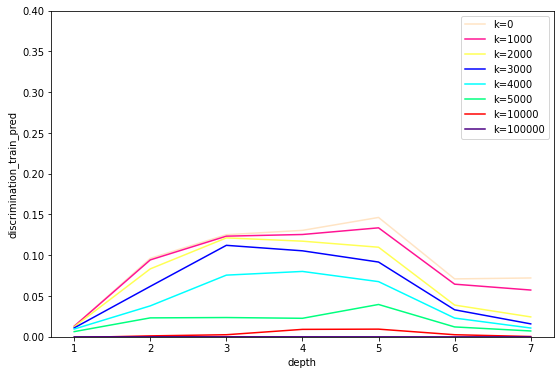

In [5]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

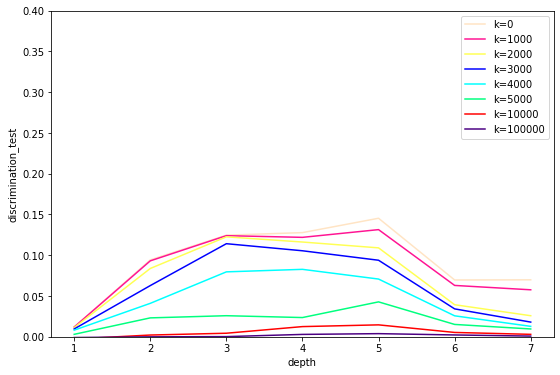

In [6]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

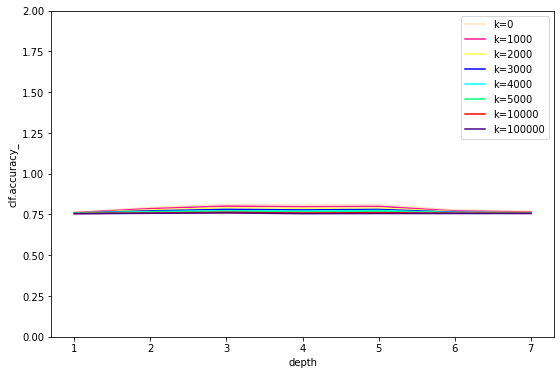

In [7]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

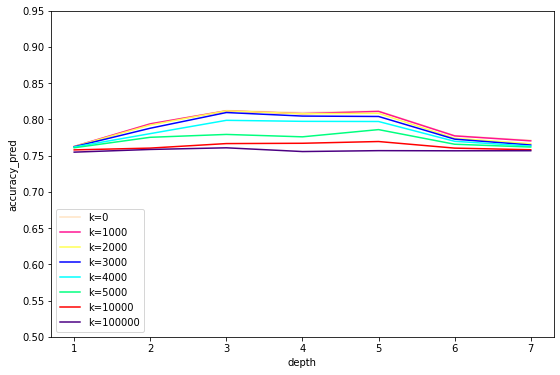

In [8]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95)

<Figure size 648x432 with 0 Axes>

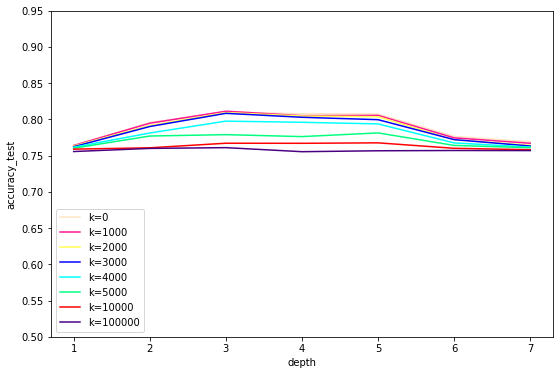

In [9]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95)

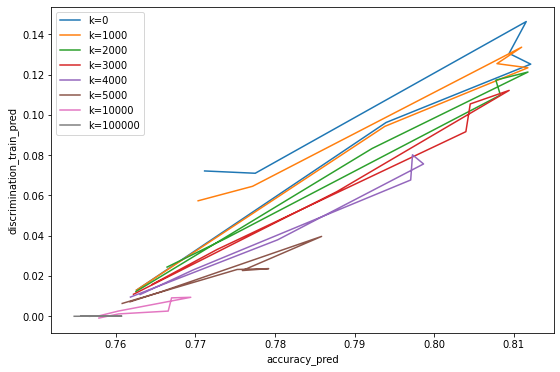

In [10]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

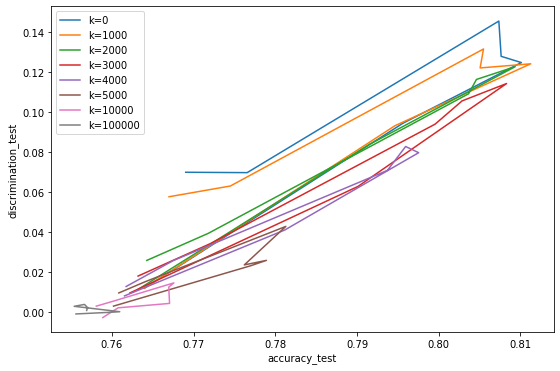

In [11]:
utils.plot2("accuracy_test", "discrimination_test", result)

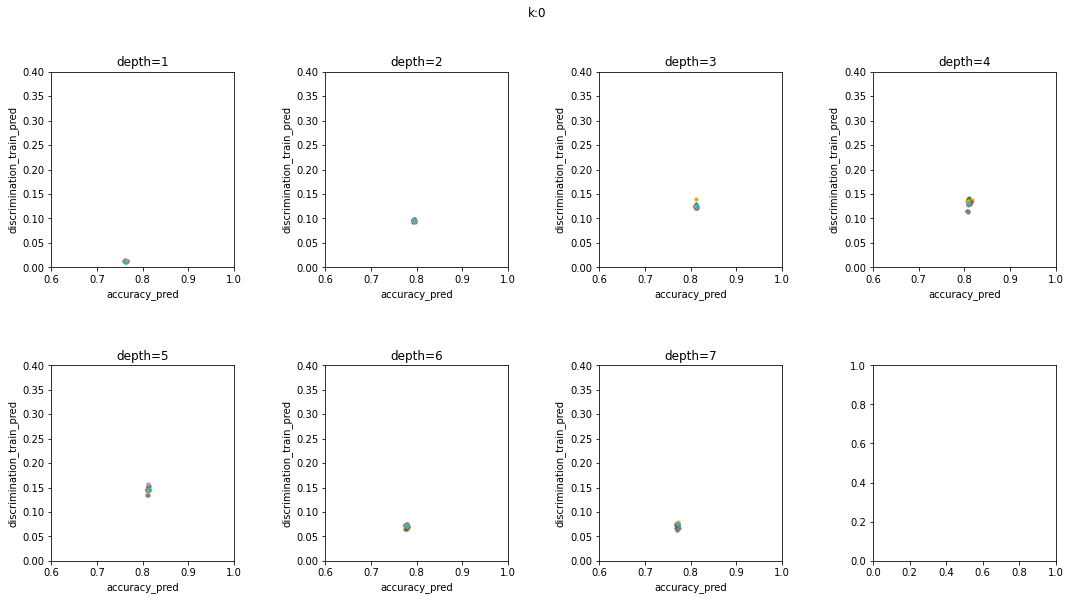

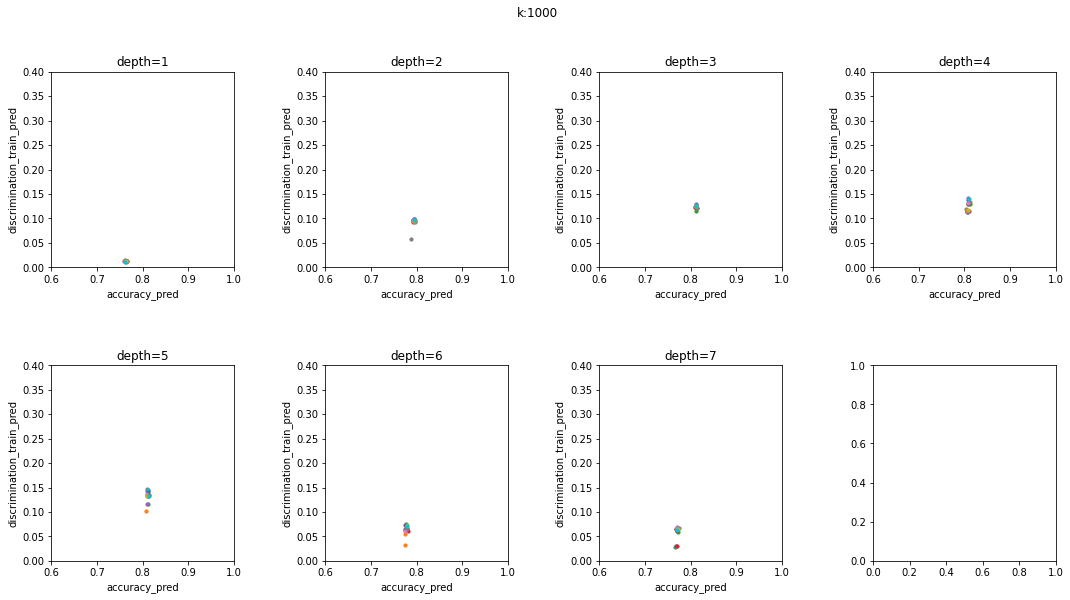

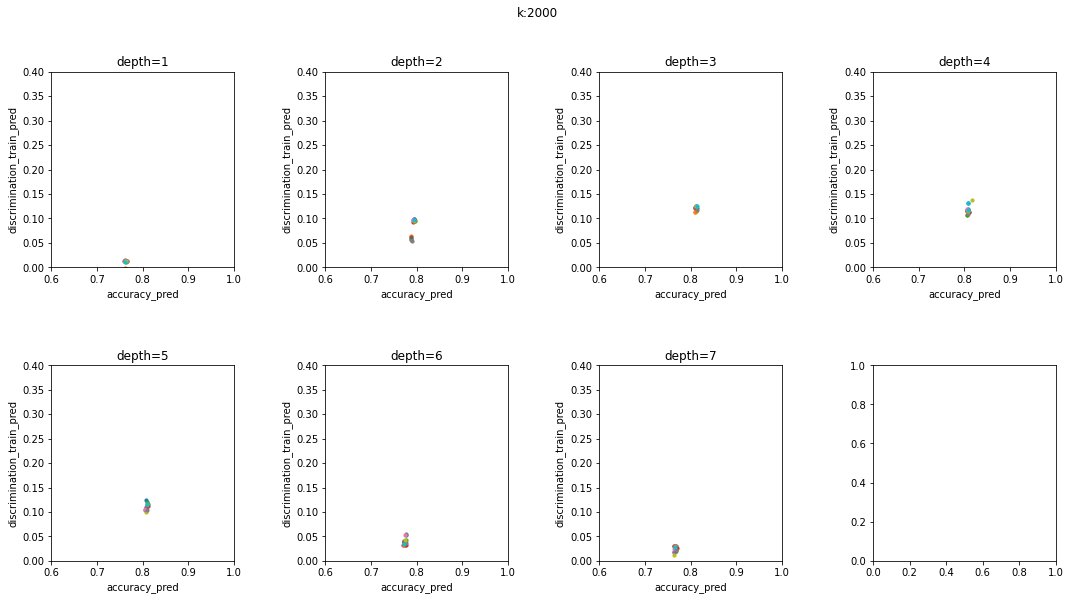

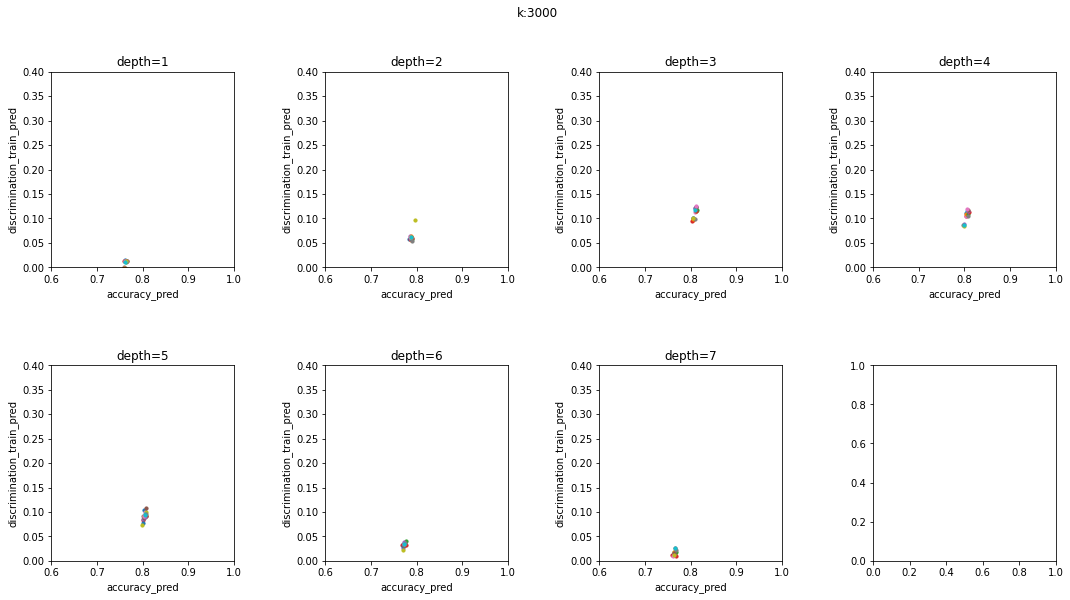

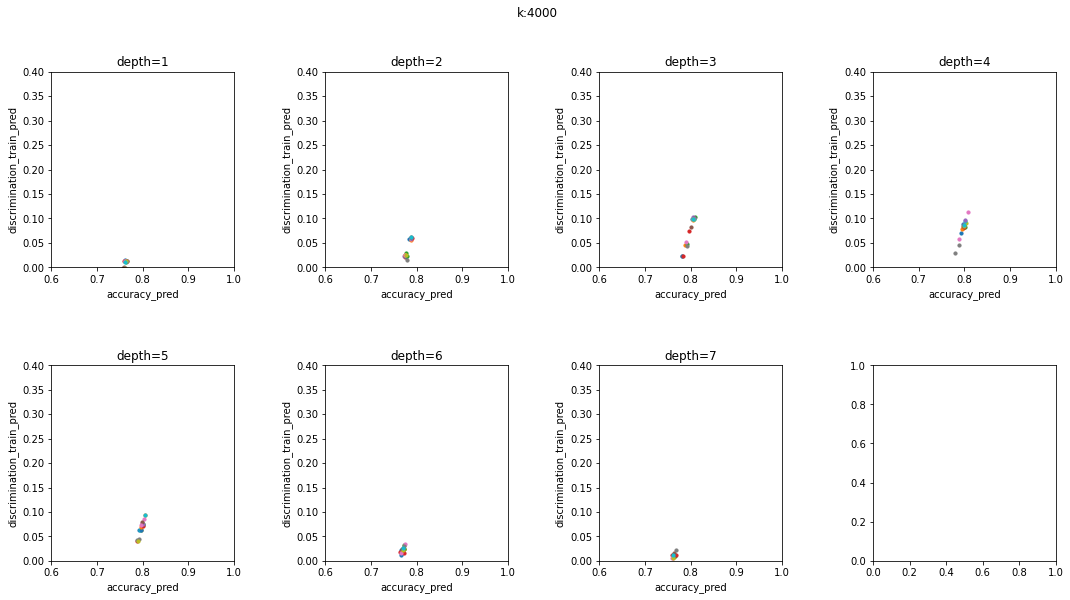

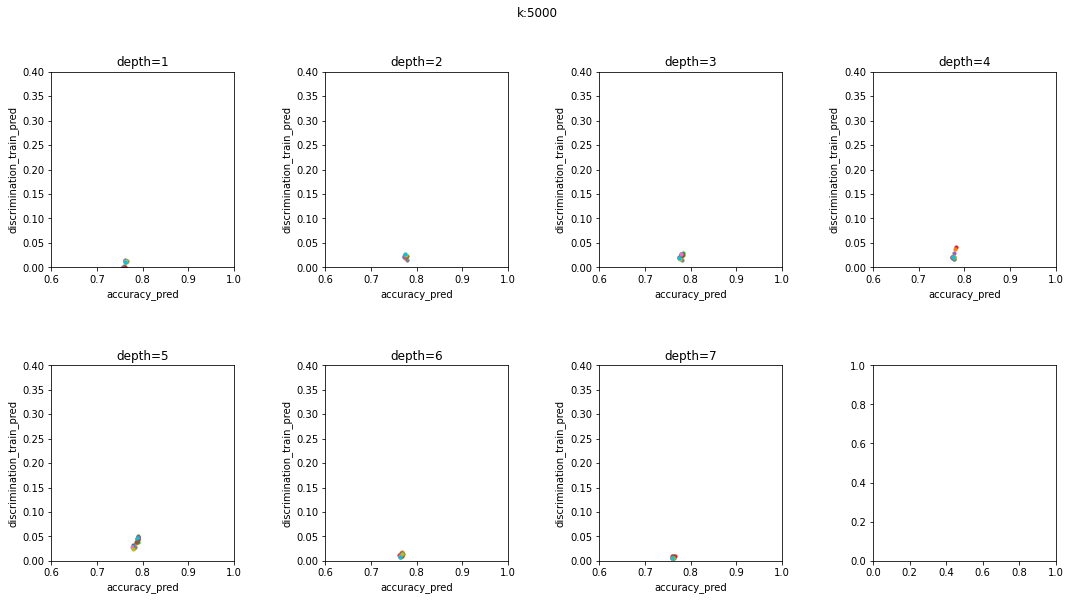

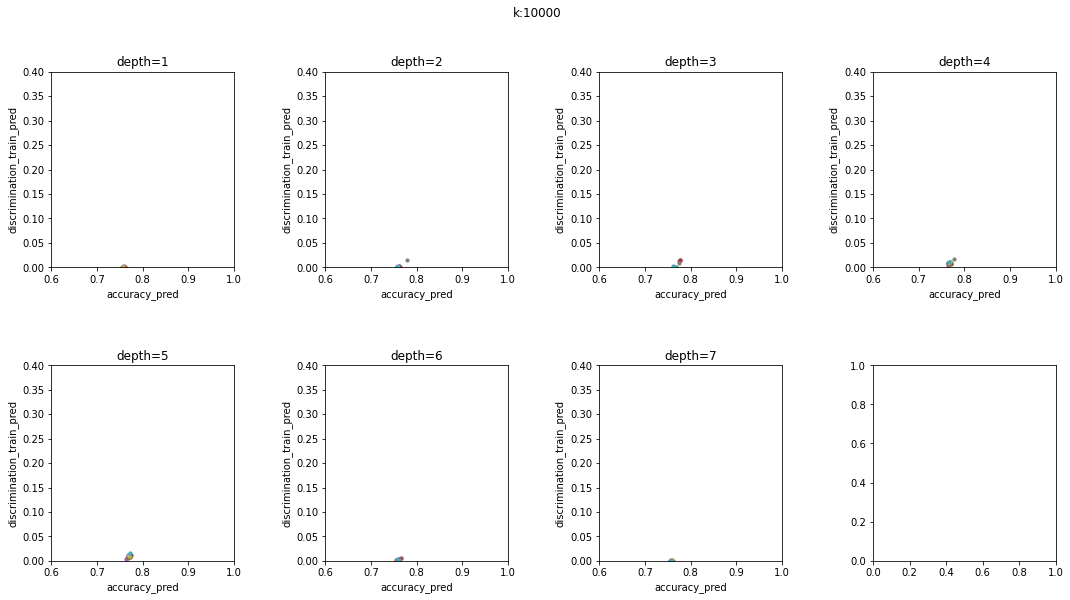

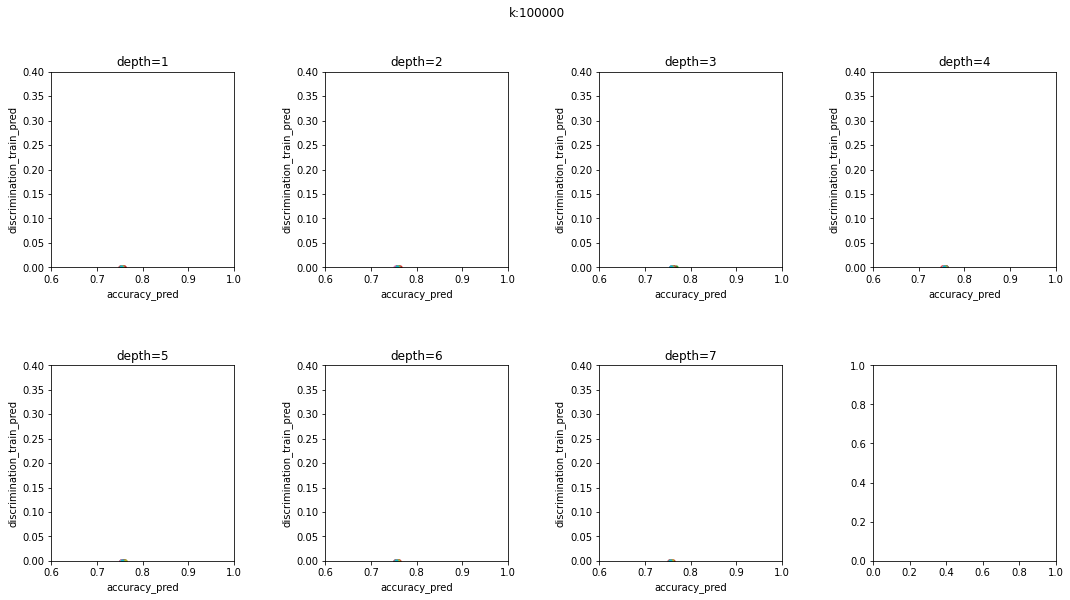

In [12]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

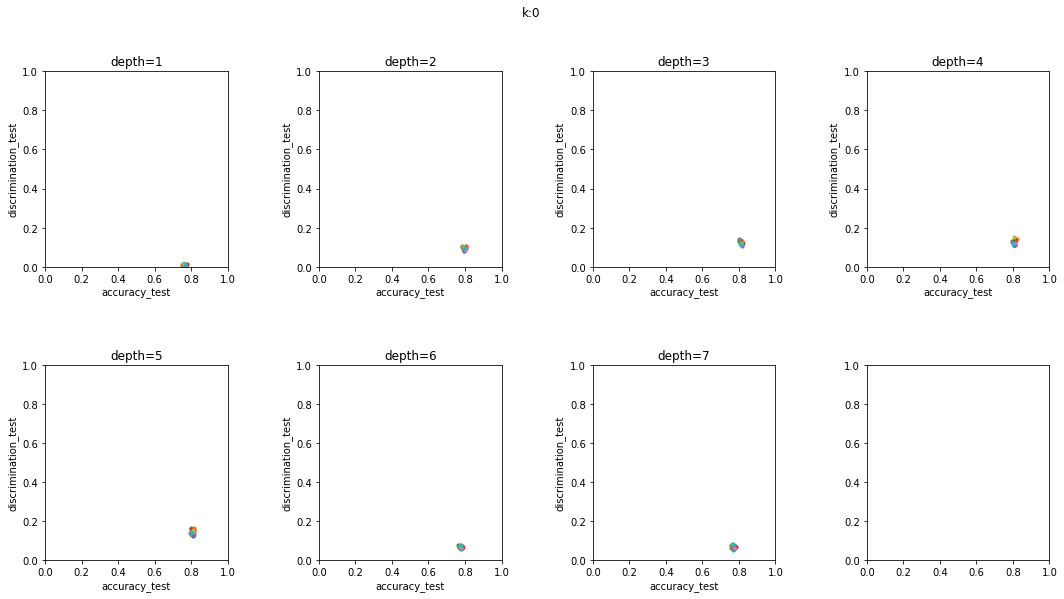

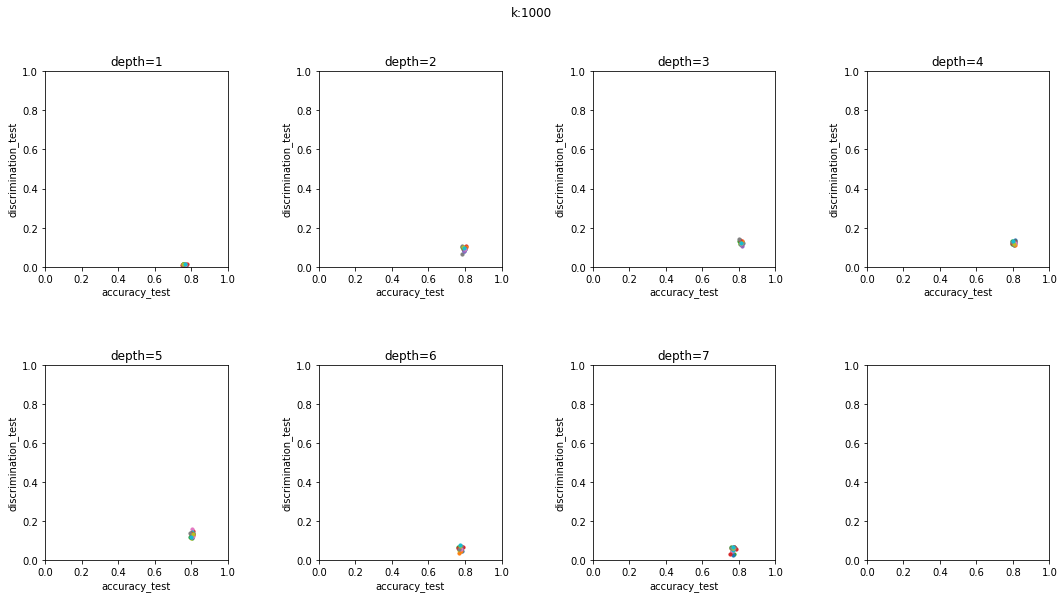

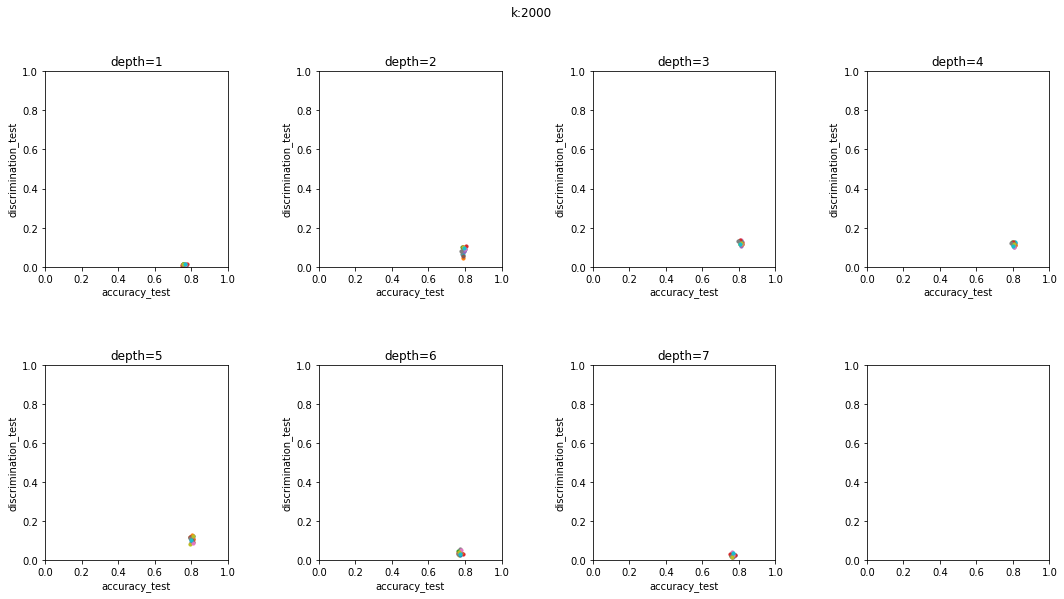

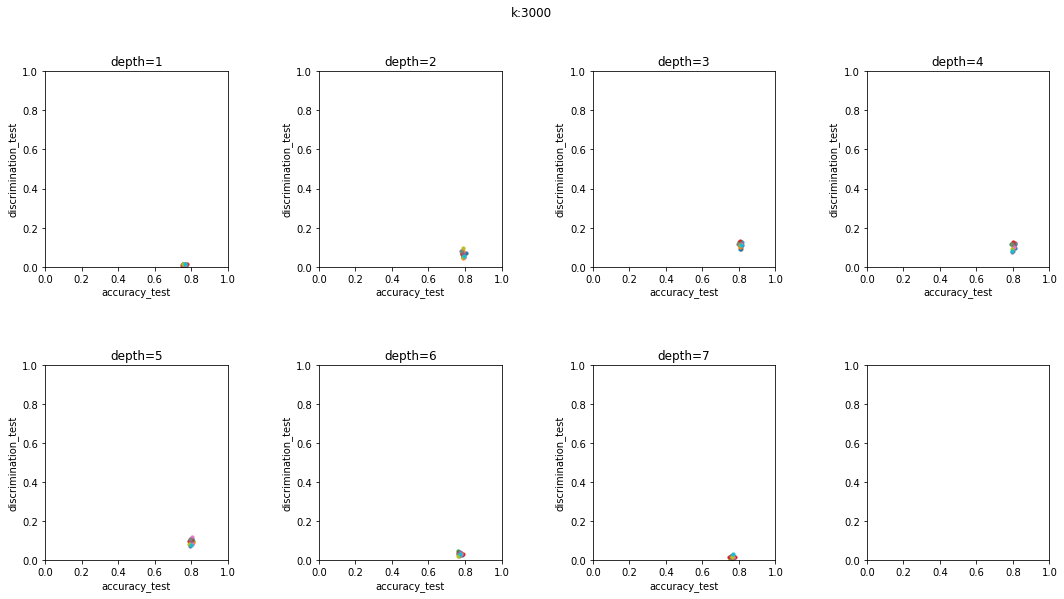

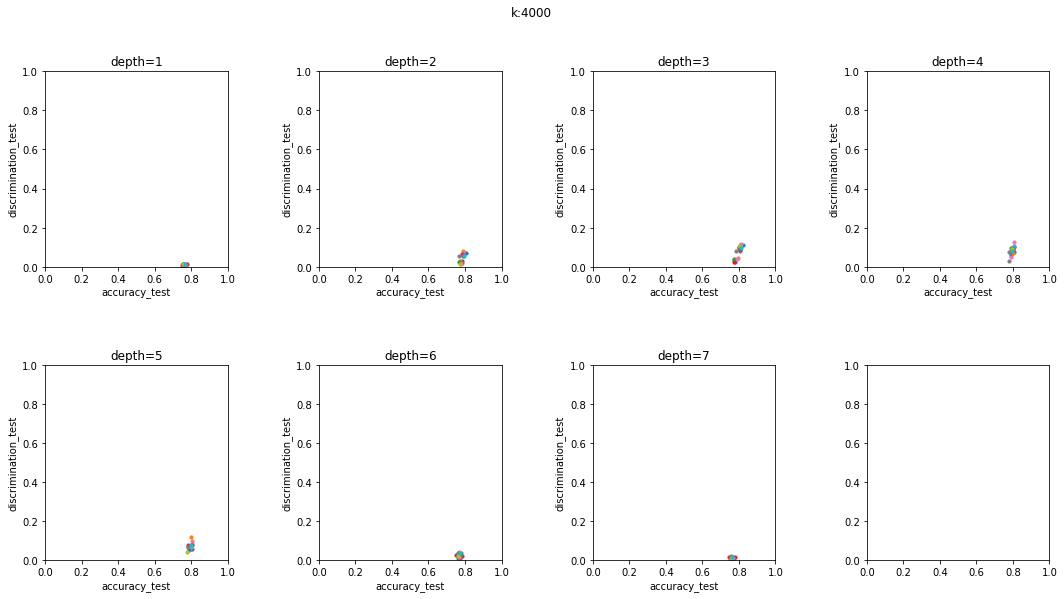

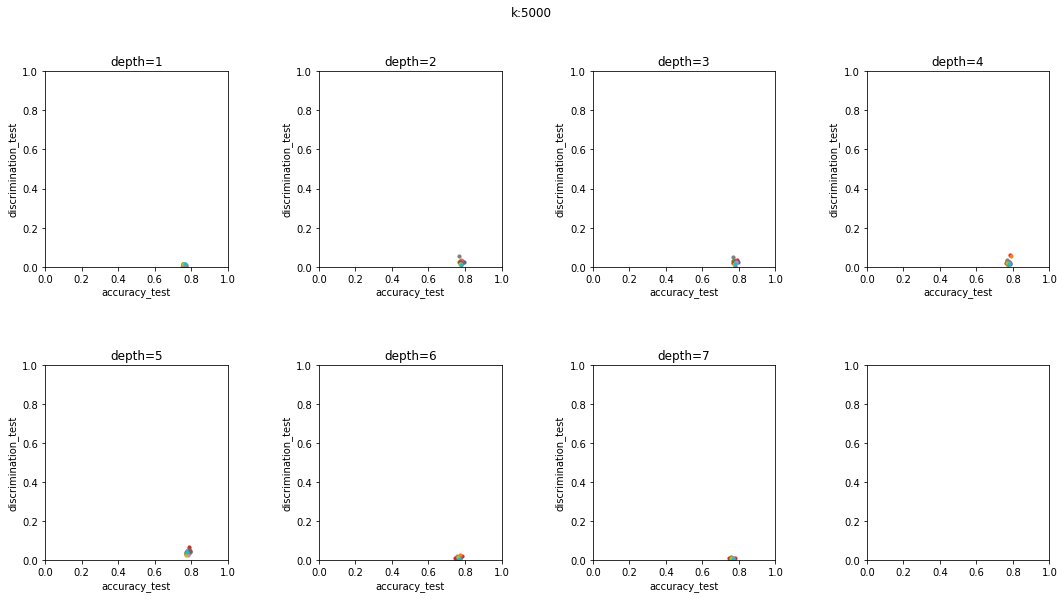

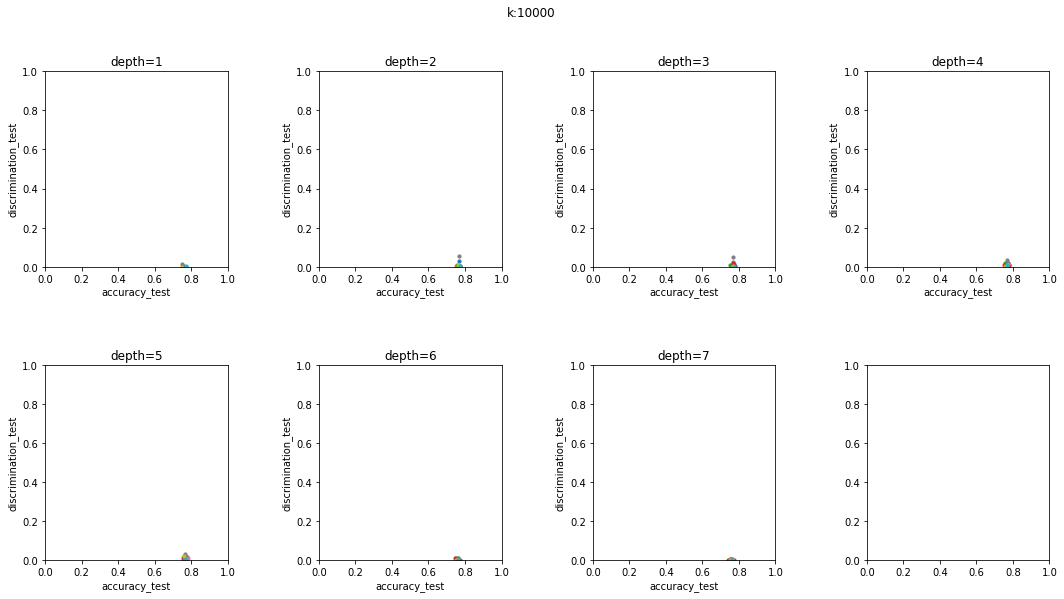

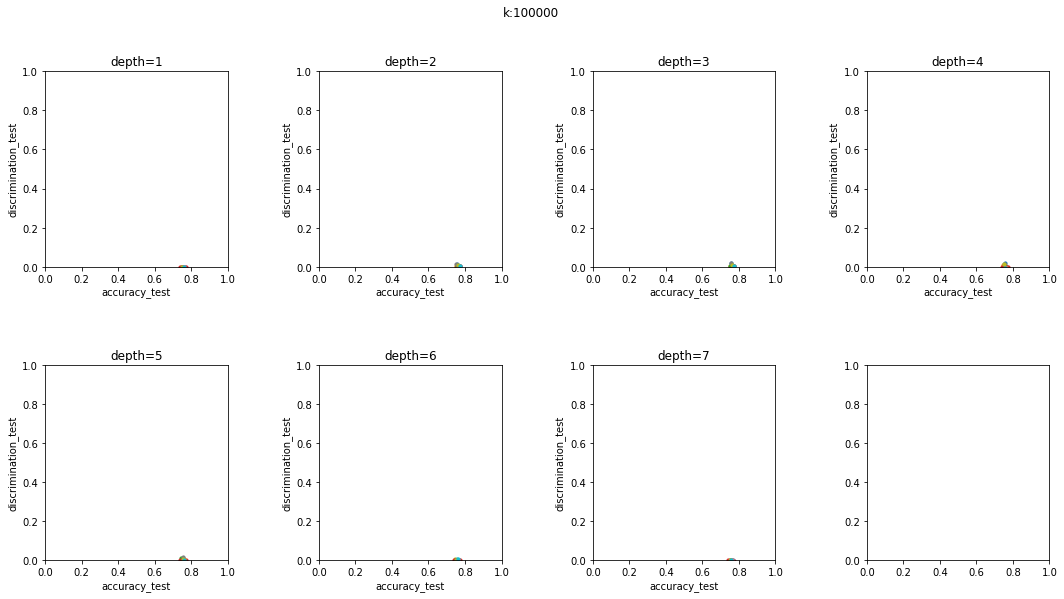

In [13]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

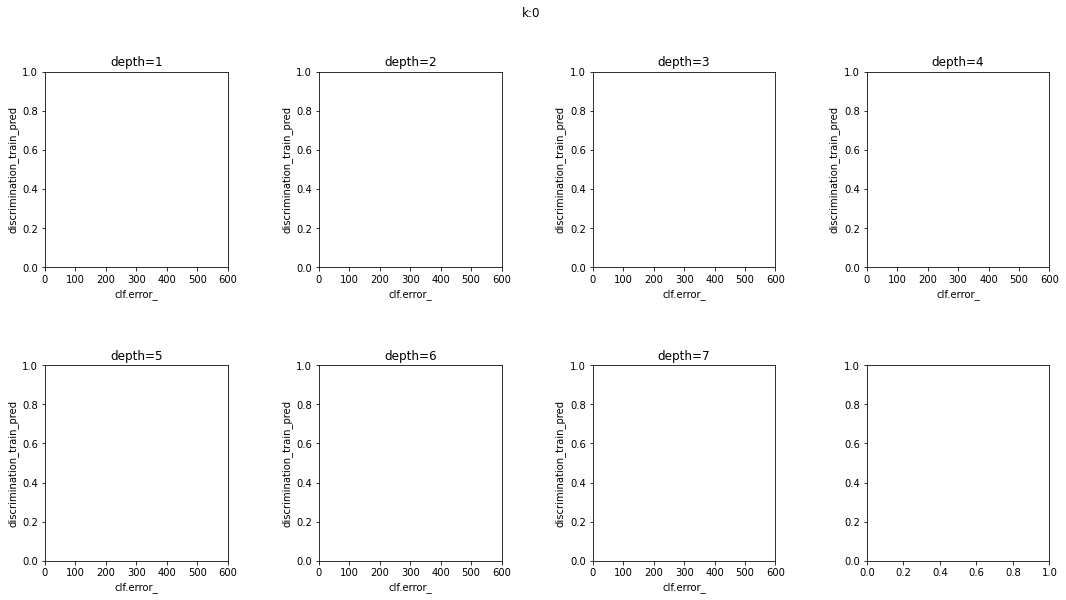

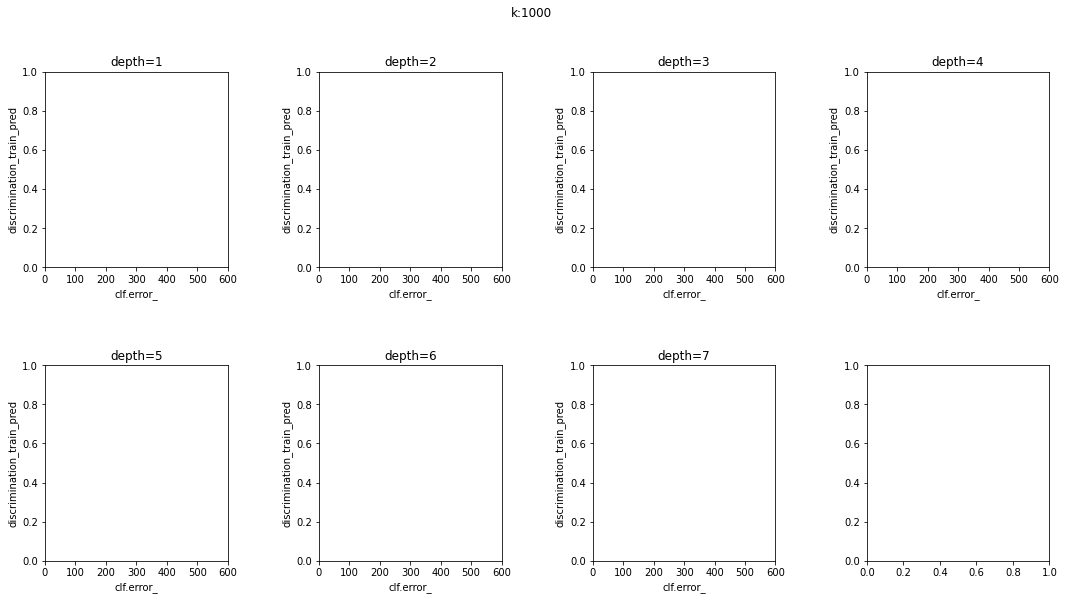

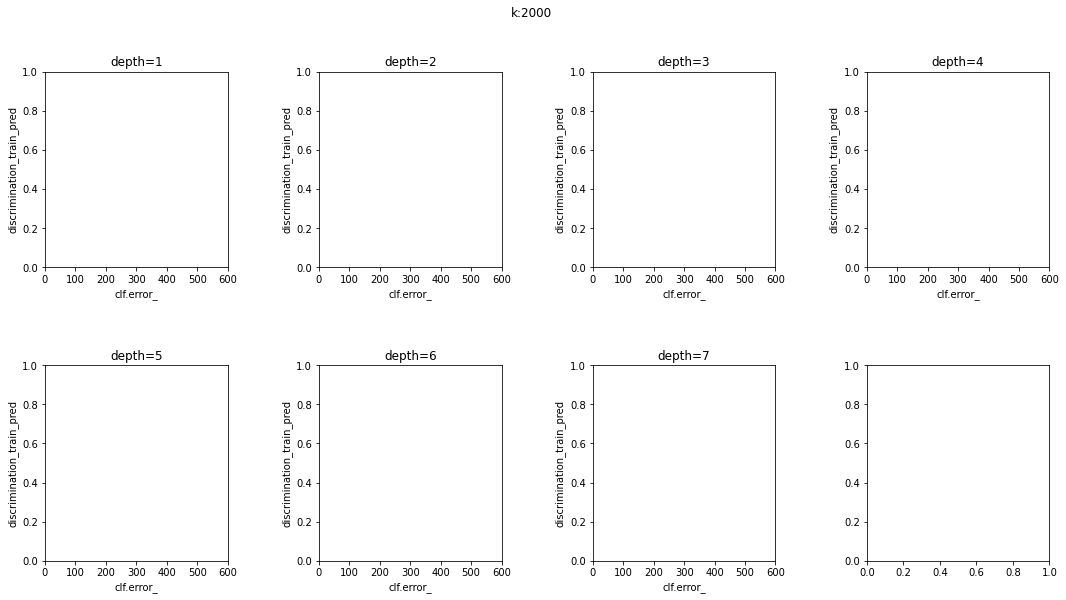

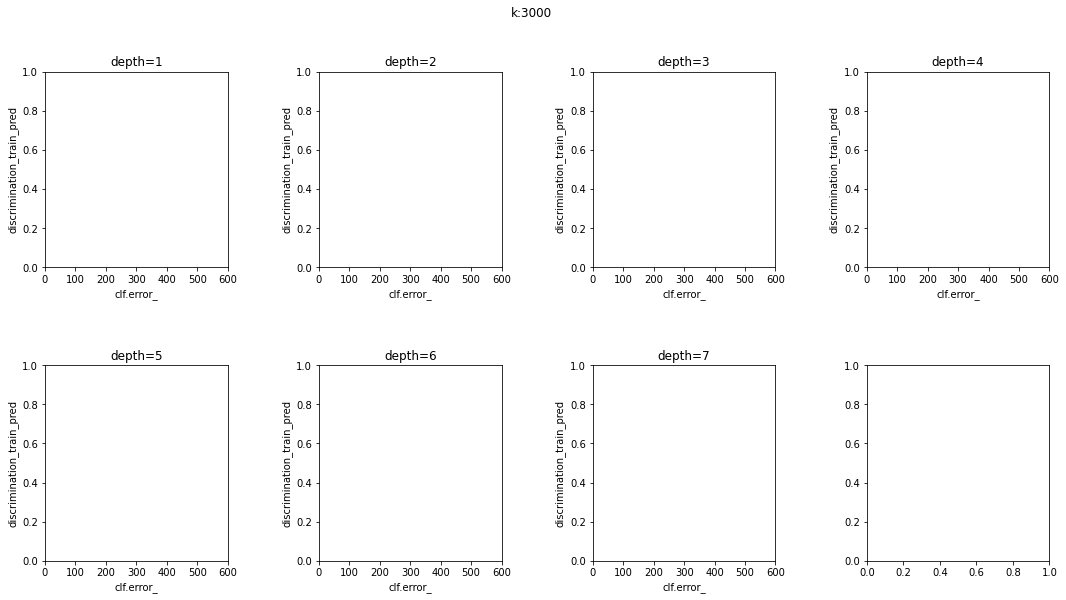

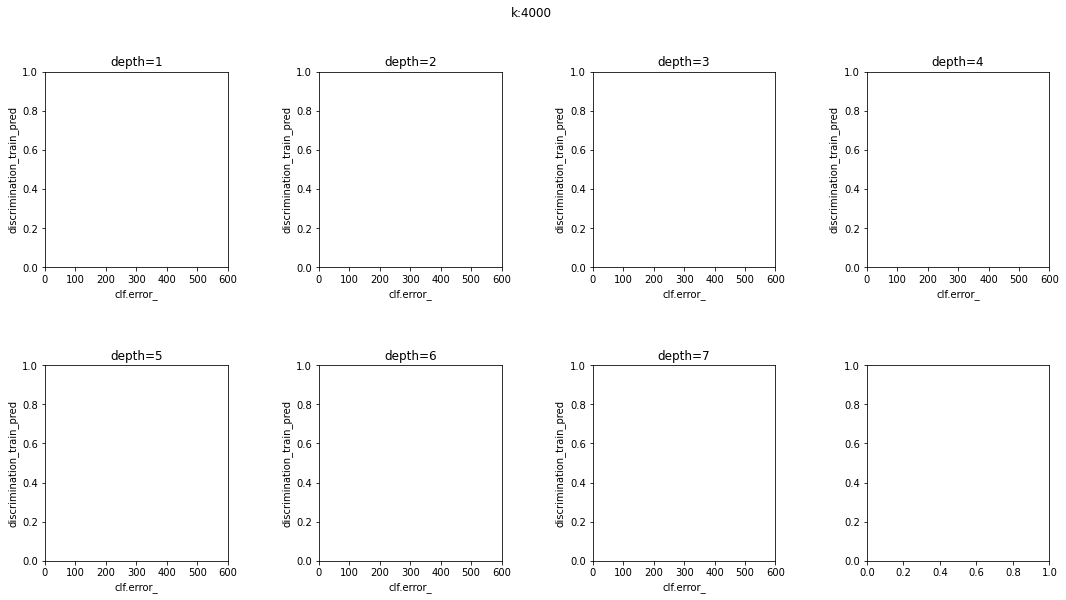

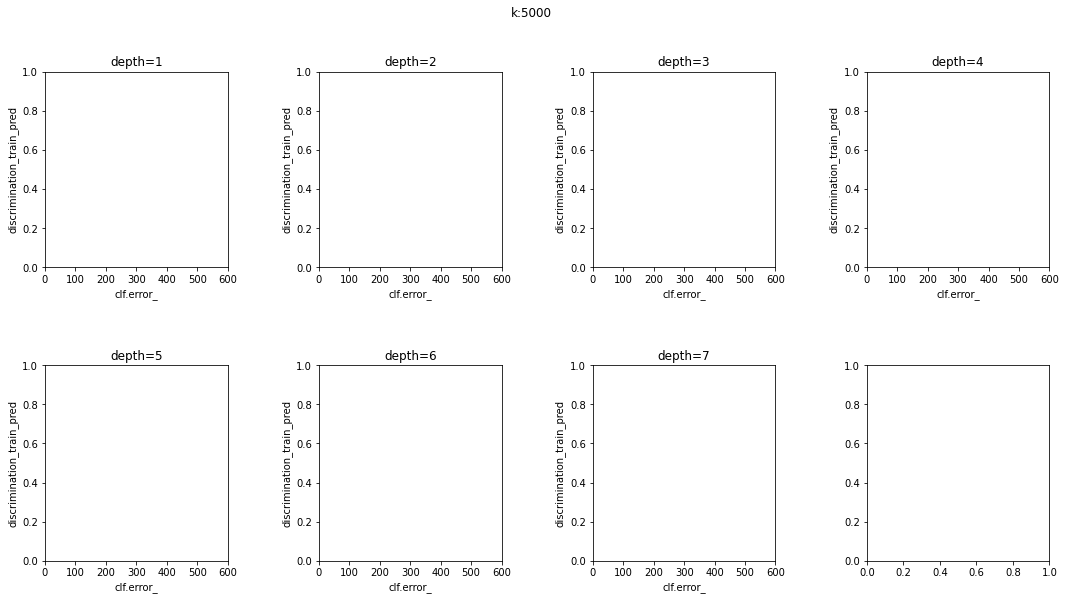

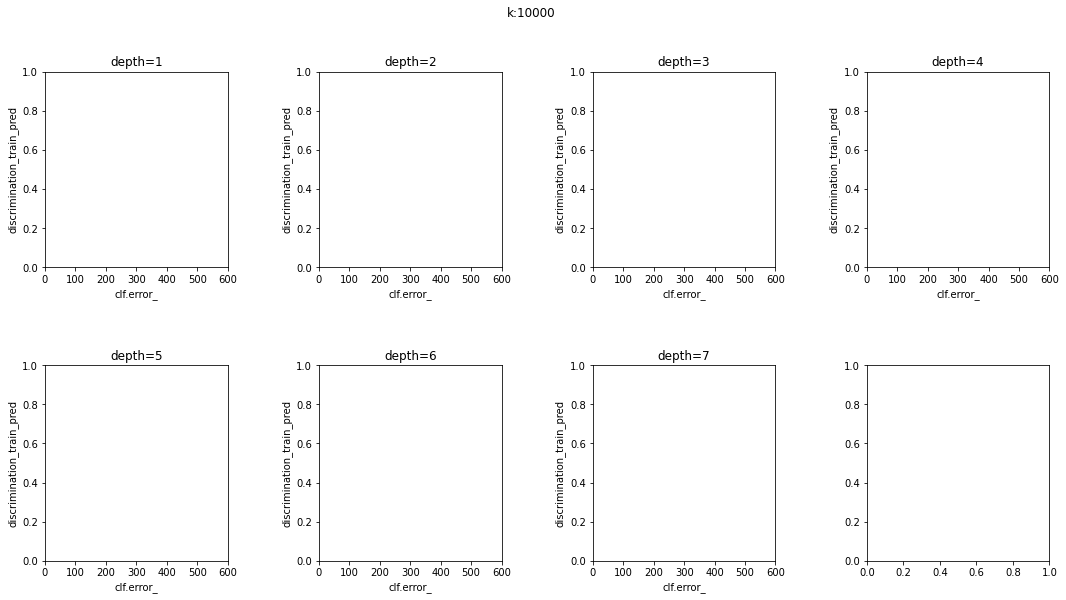

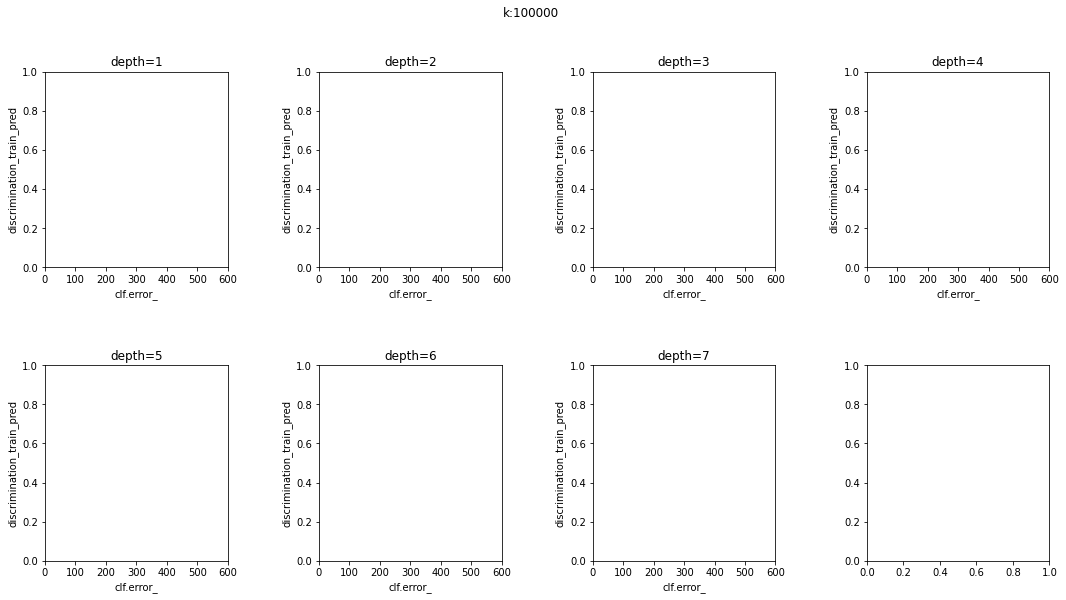

In [14]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

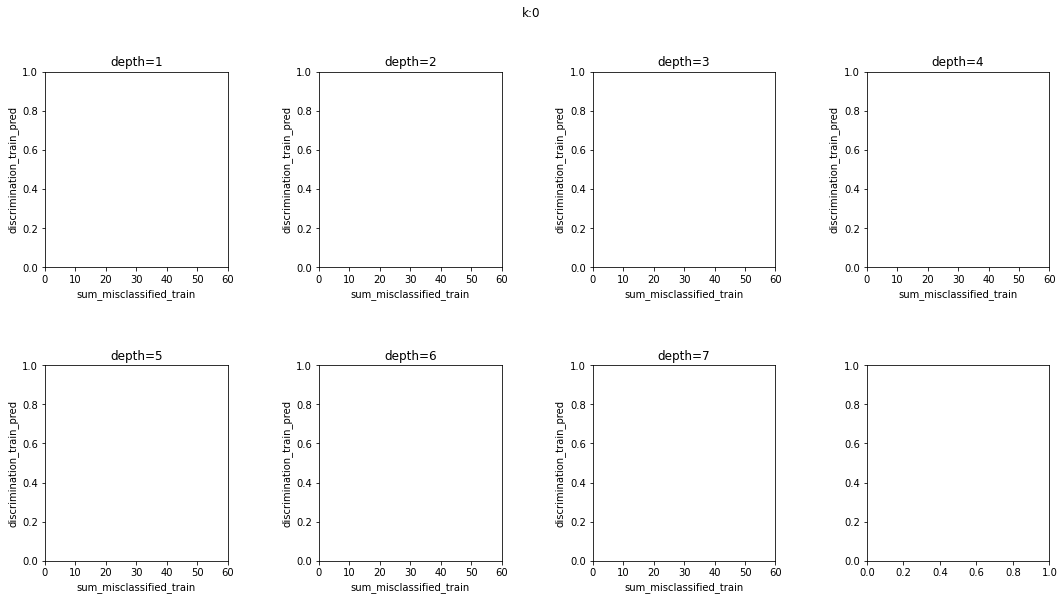

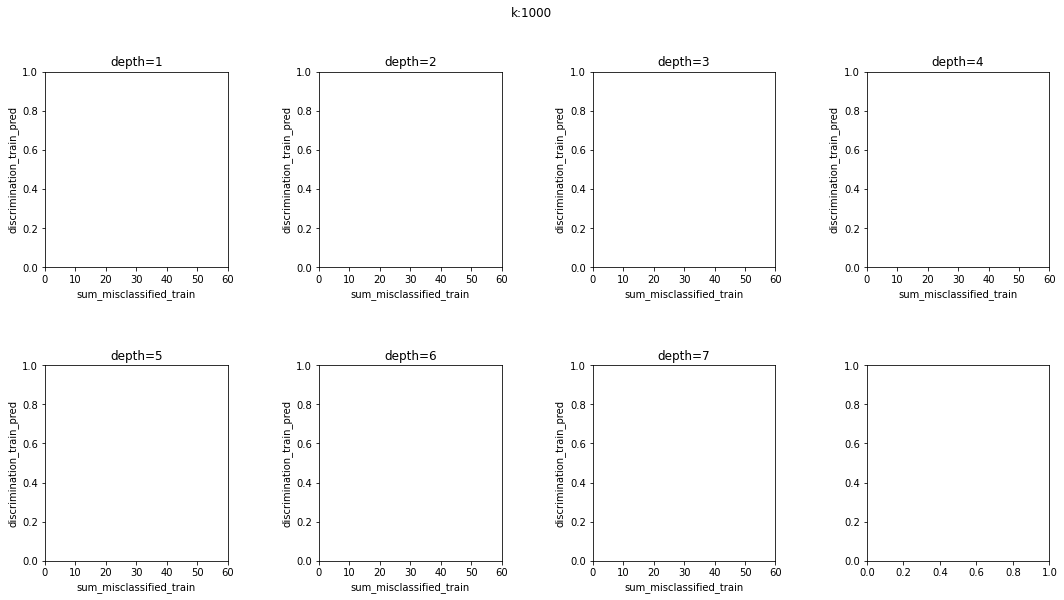

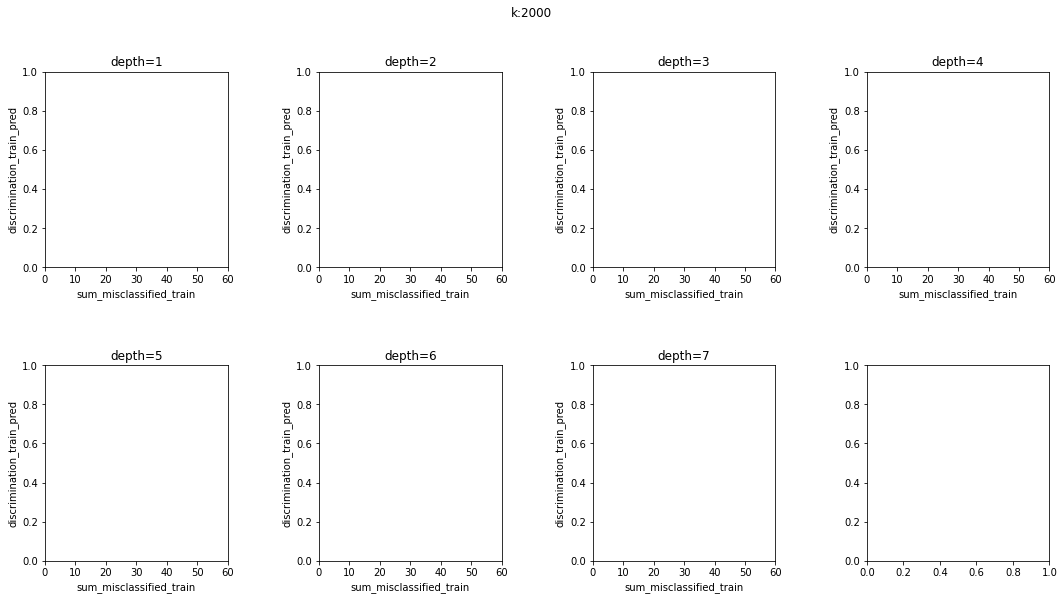

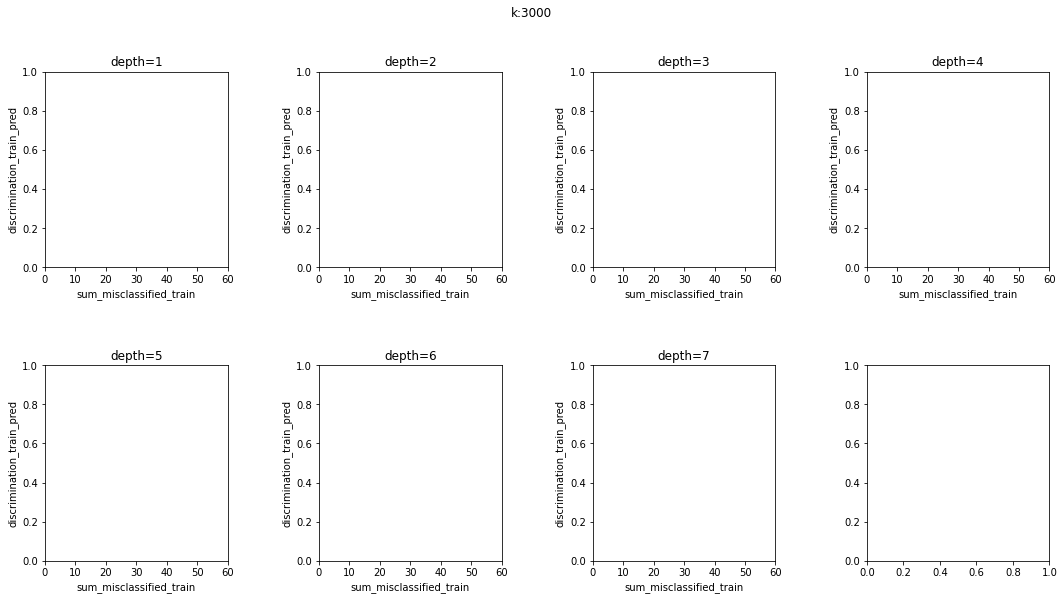

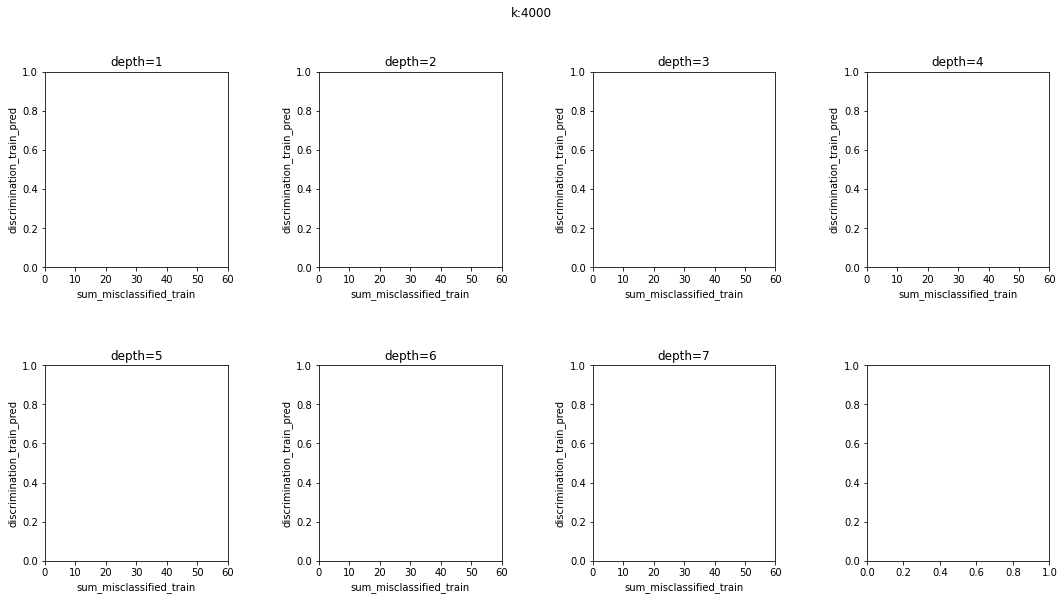

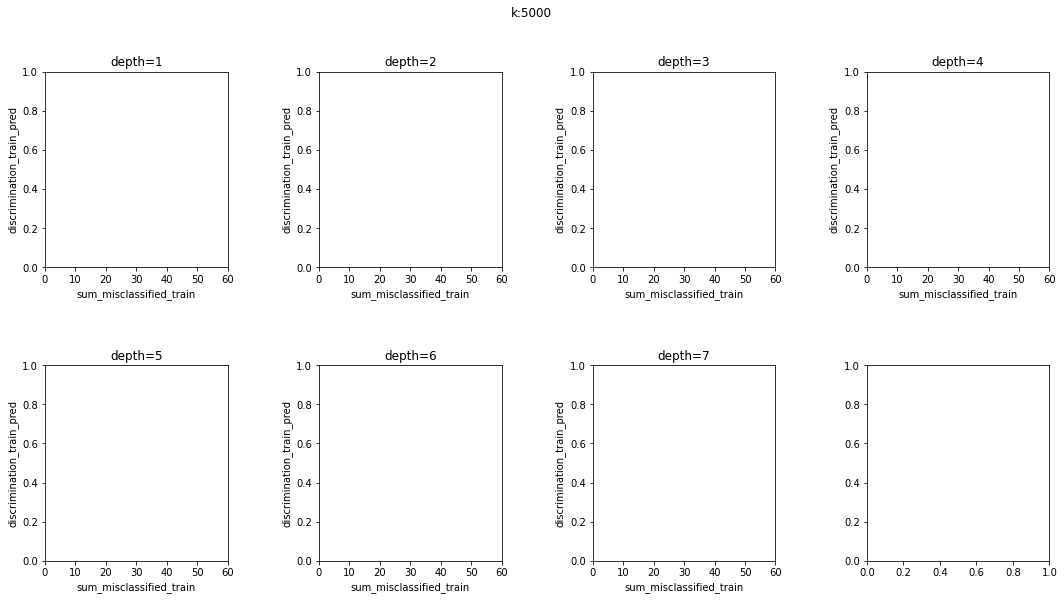

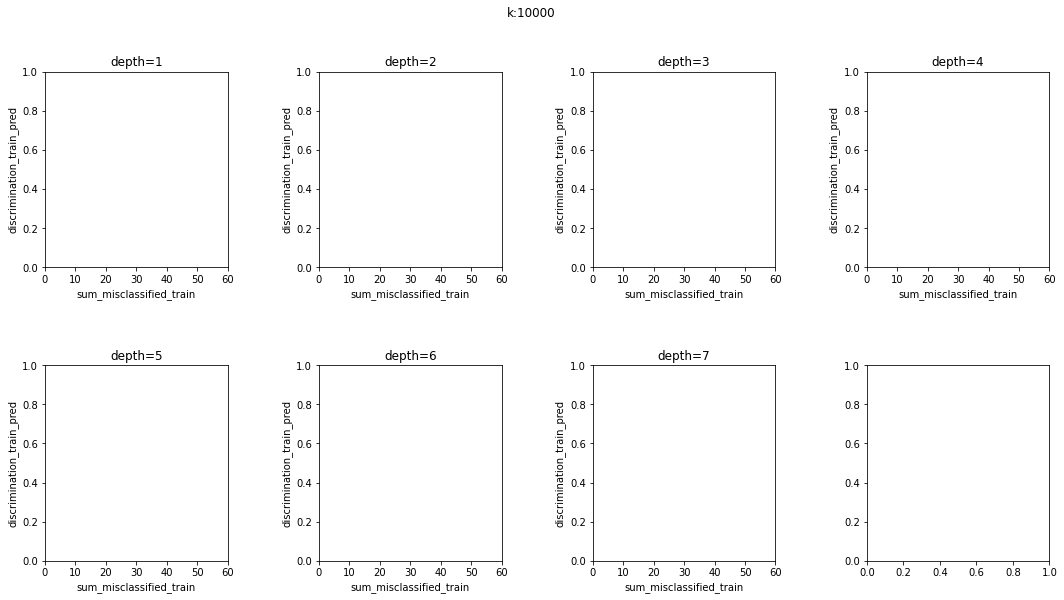

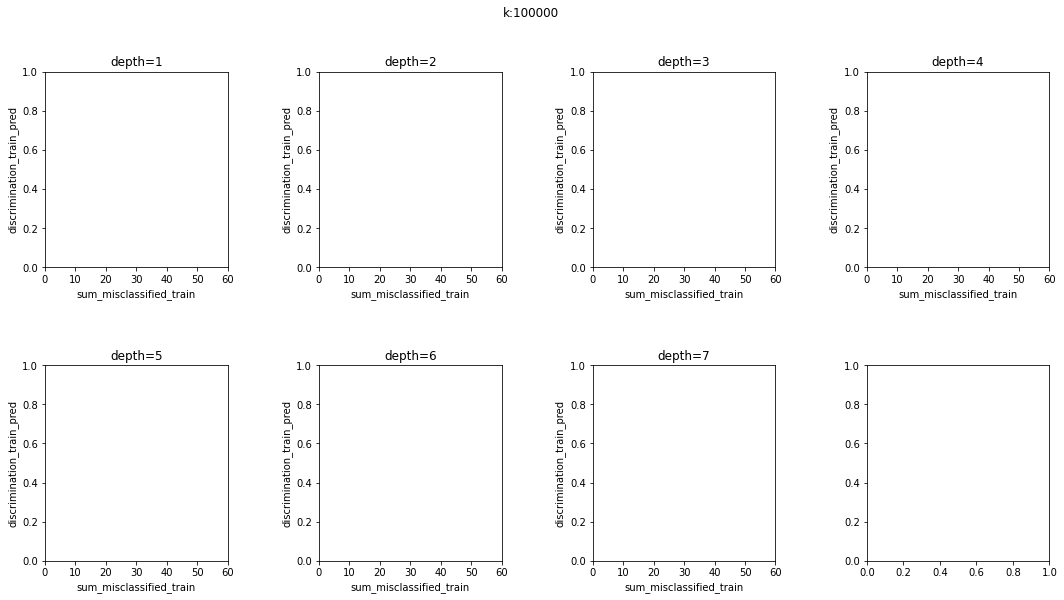

In [15]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

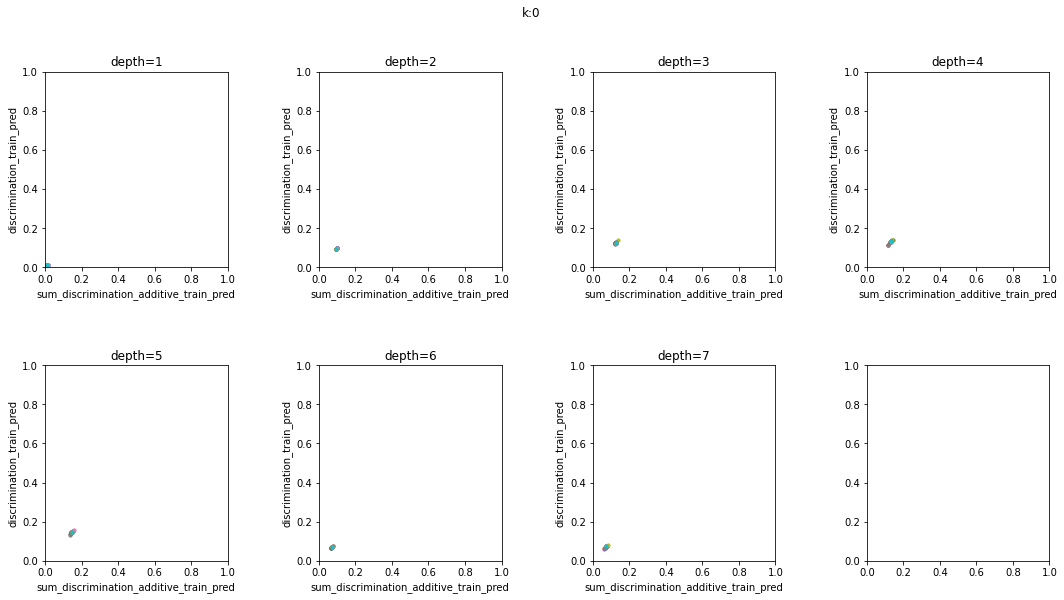

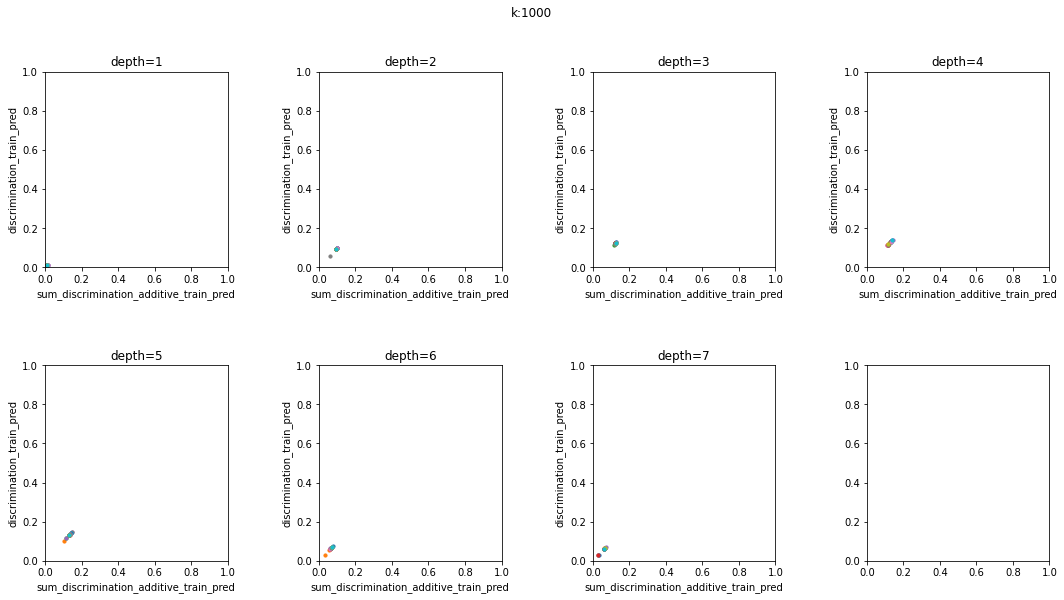

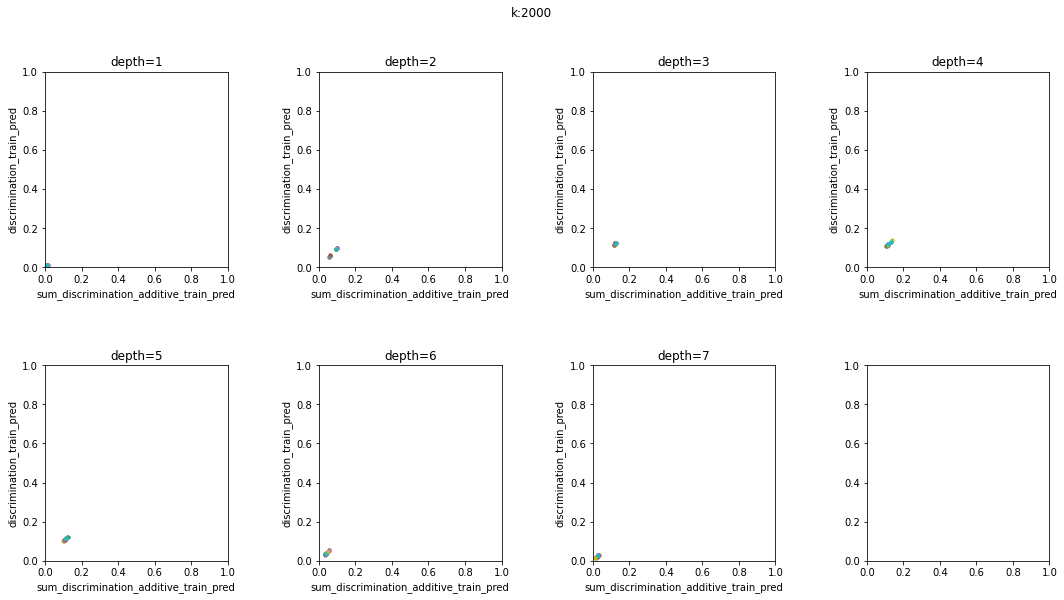

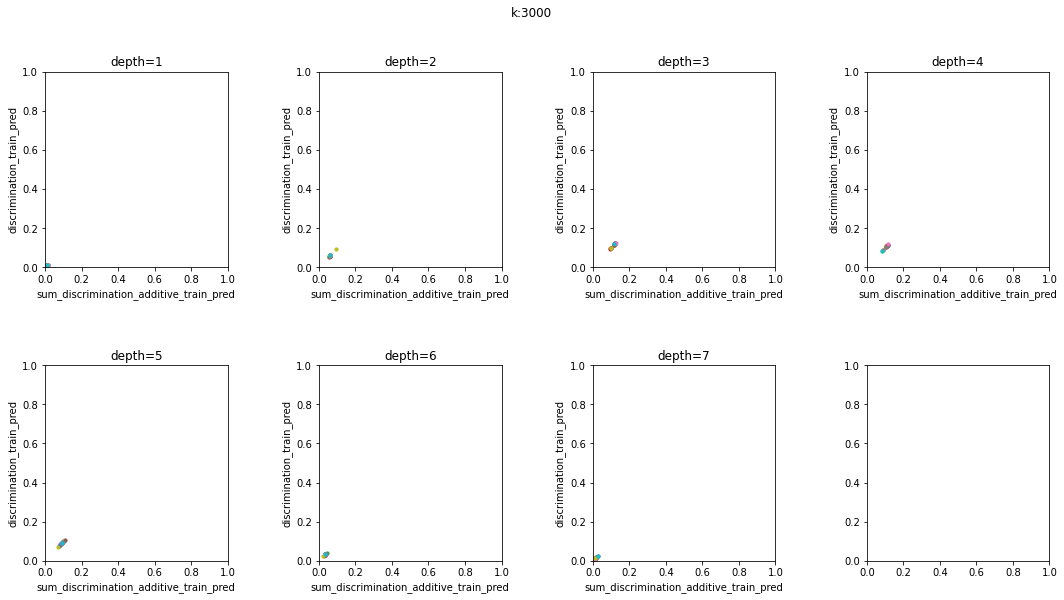

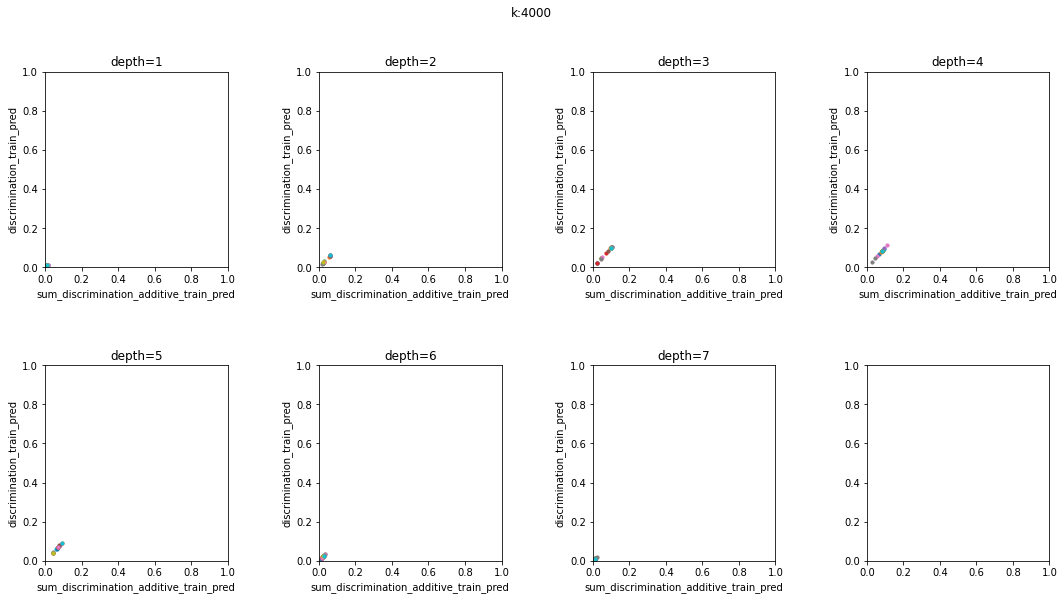

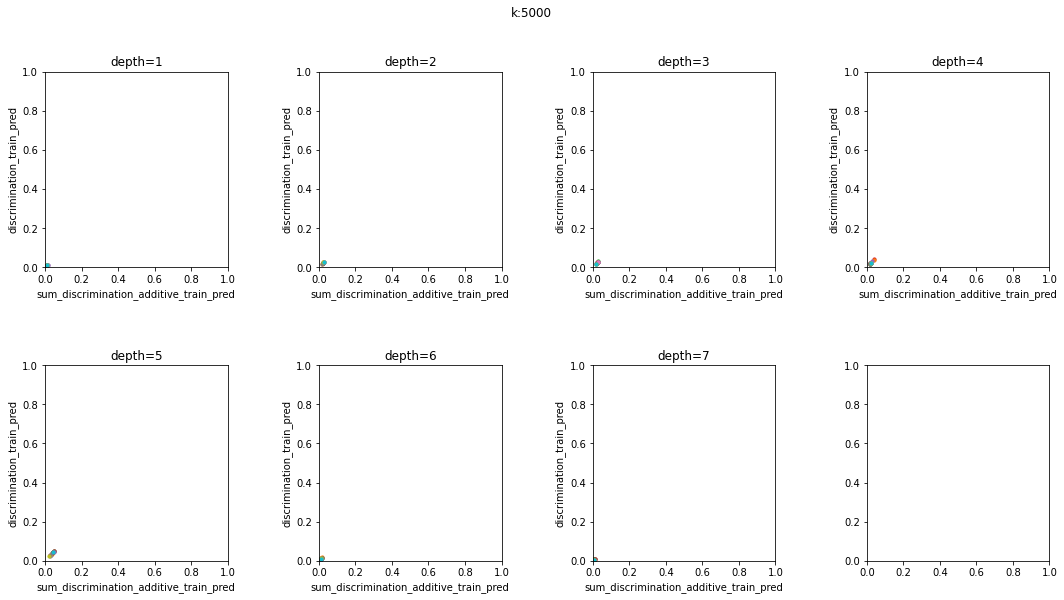

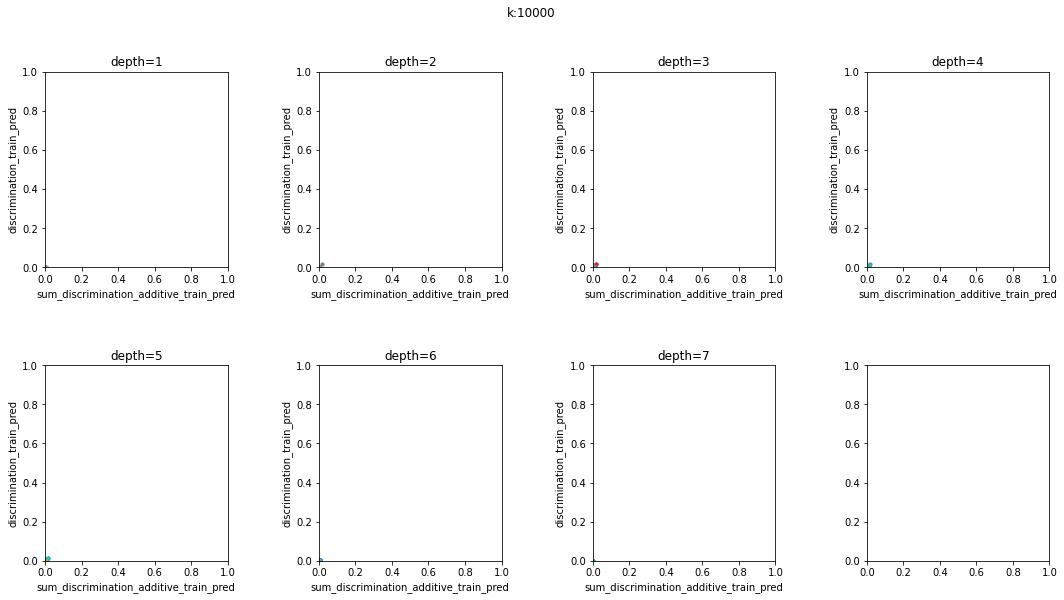

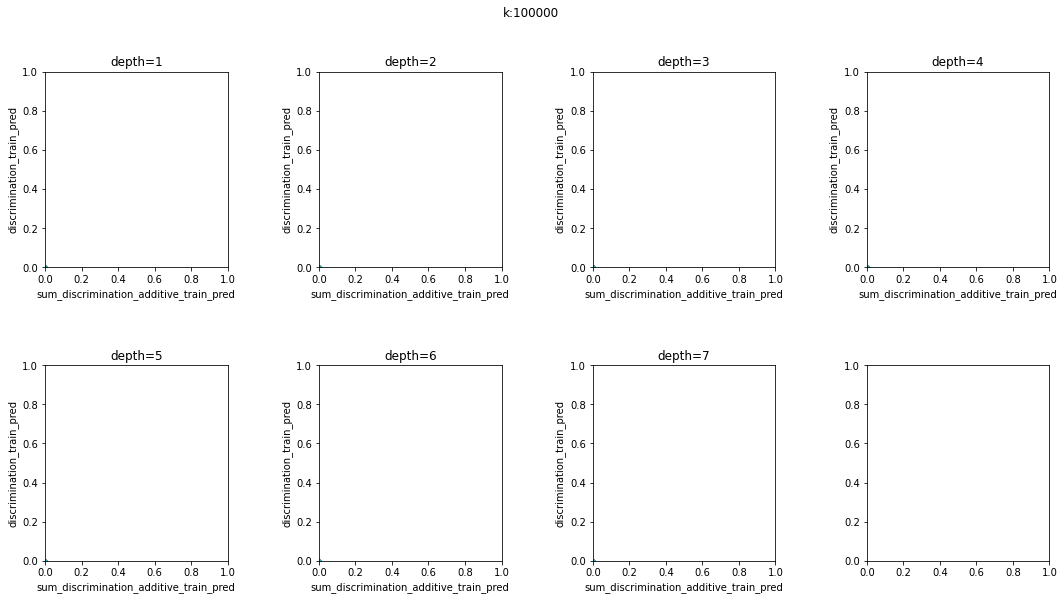

In [16]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

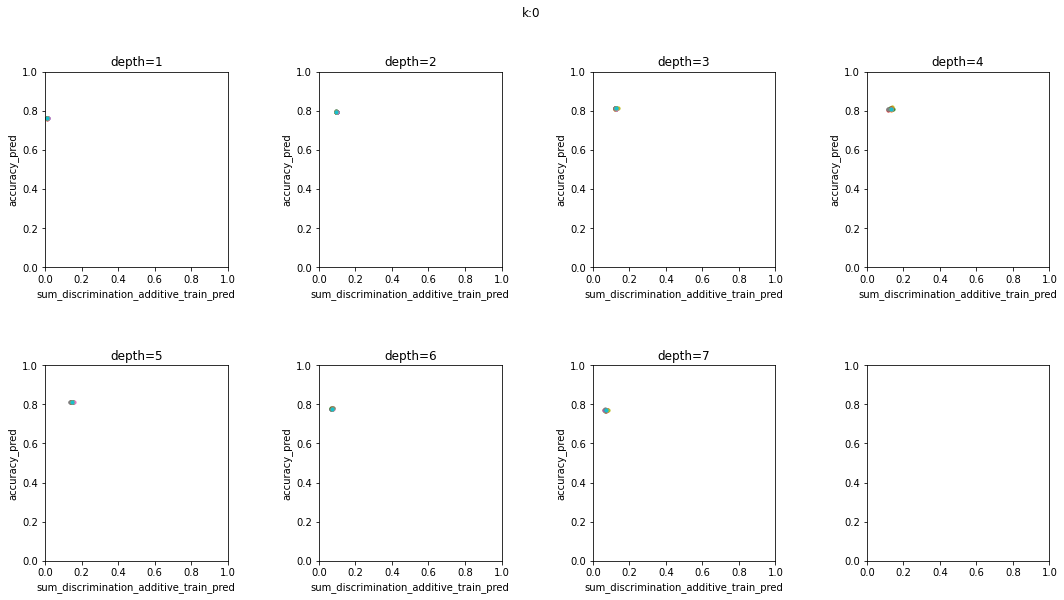

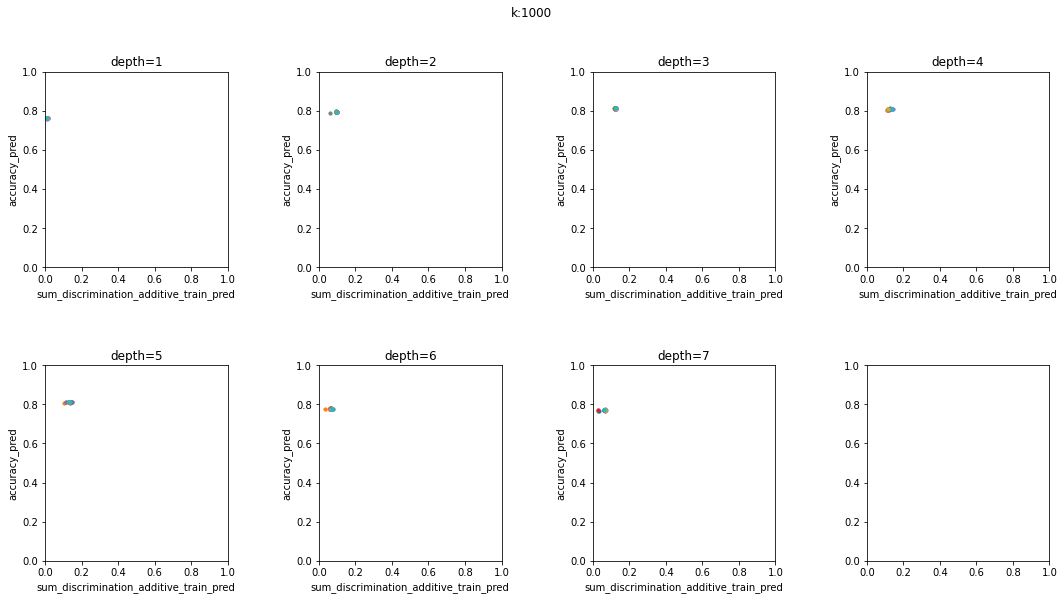

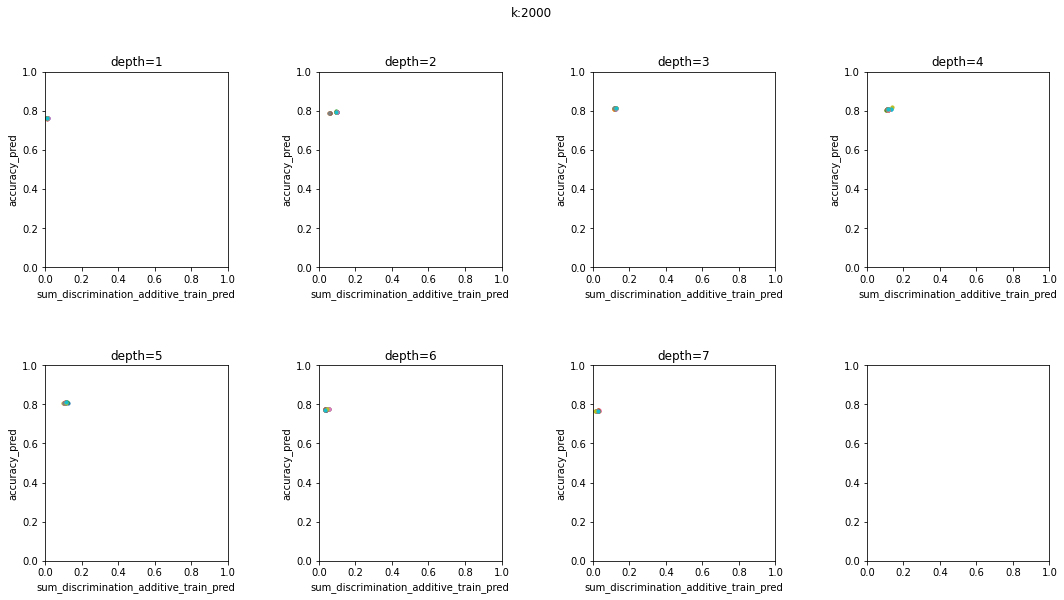

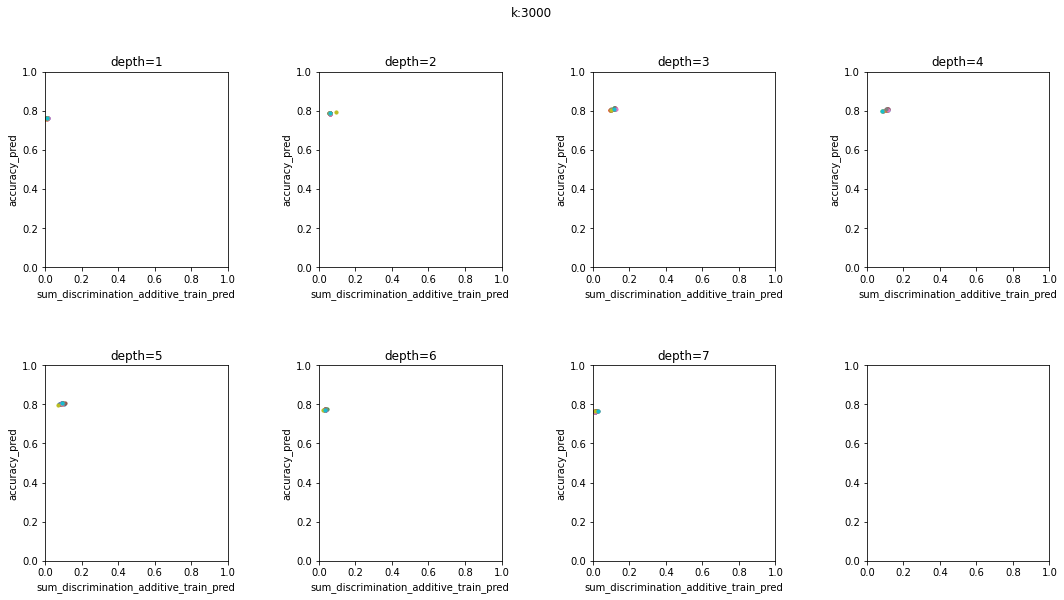

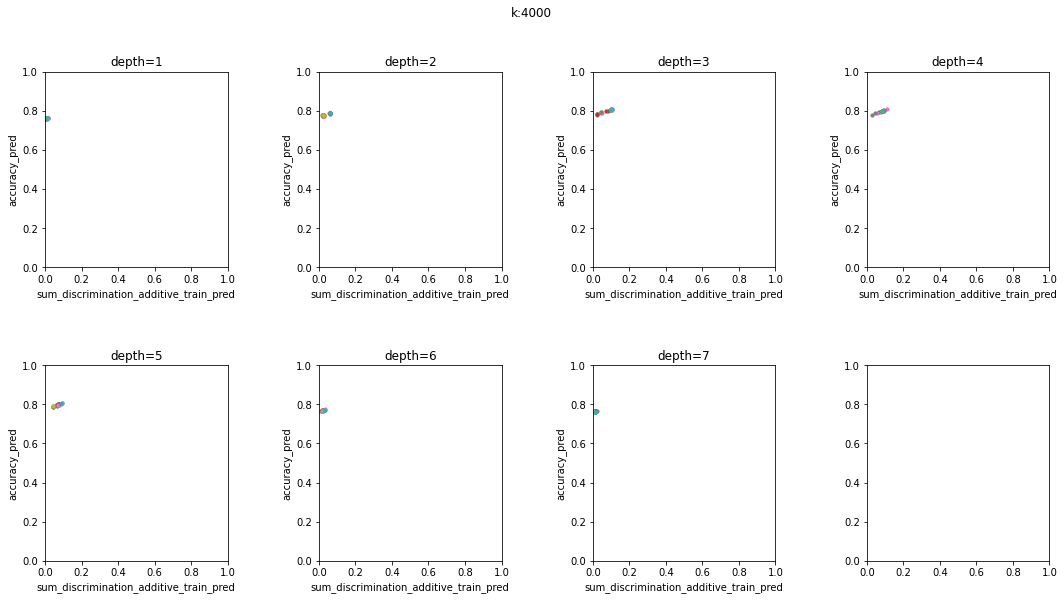

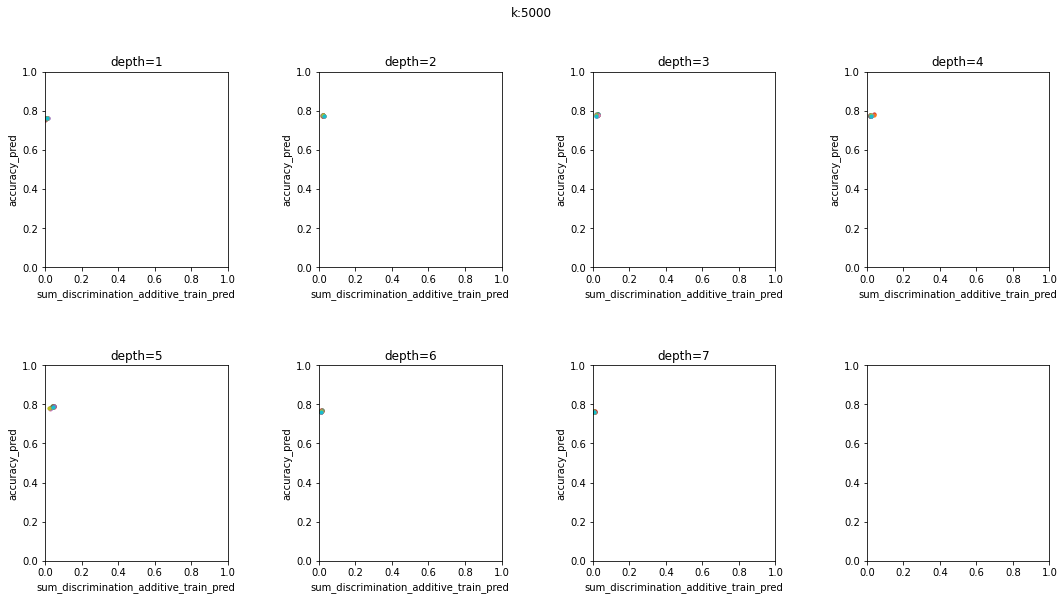

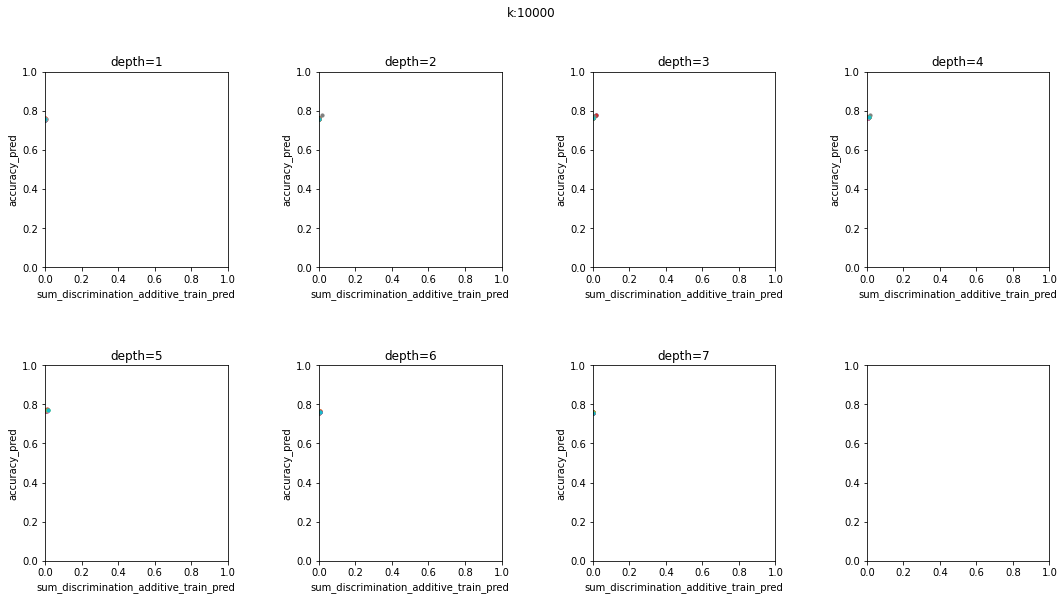

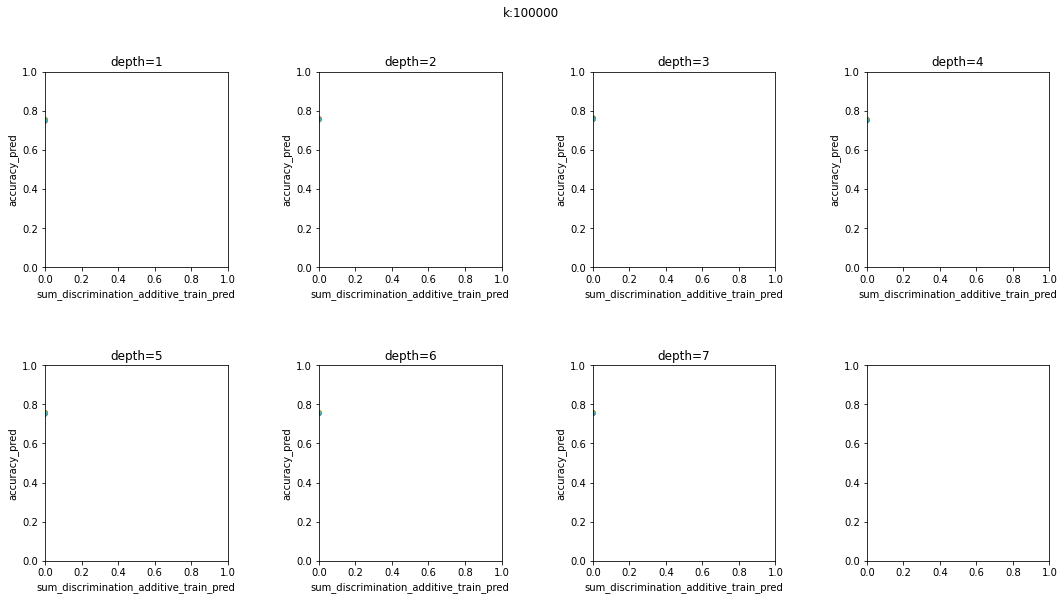

In [17]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

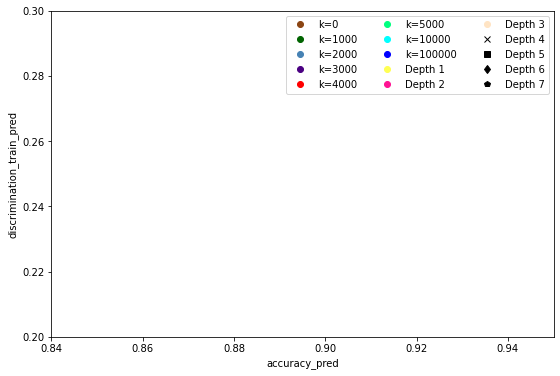

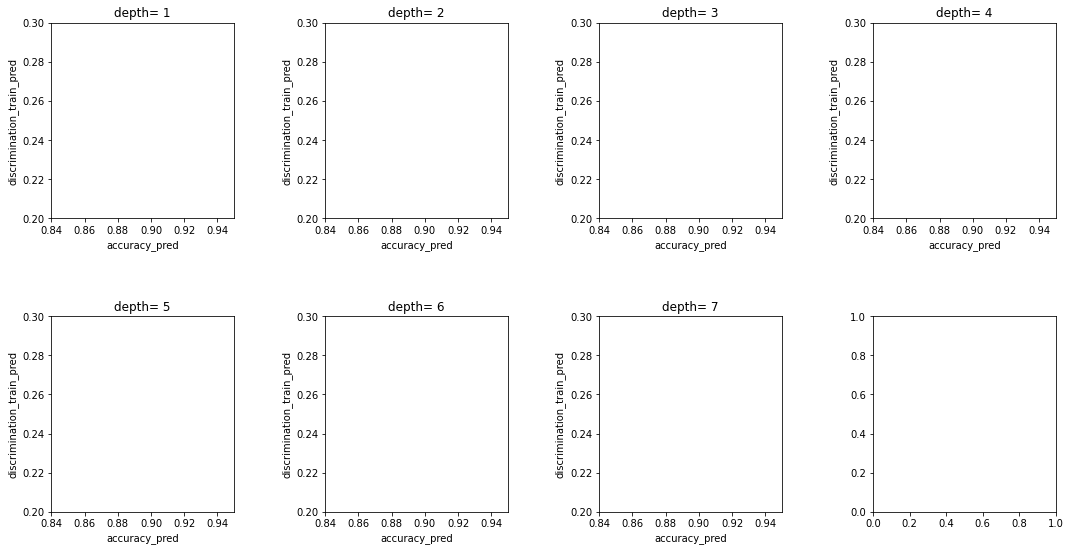

In [18]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

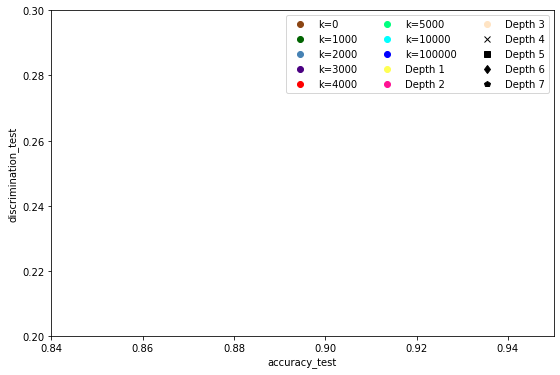

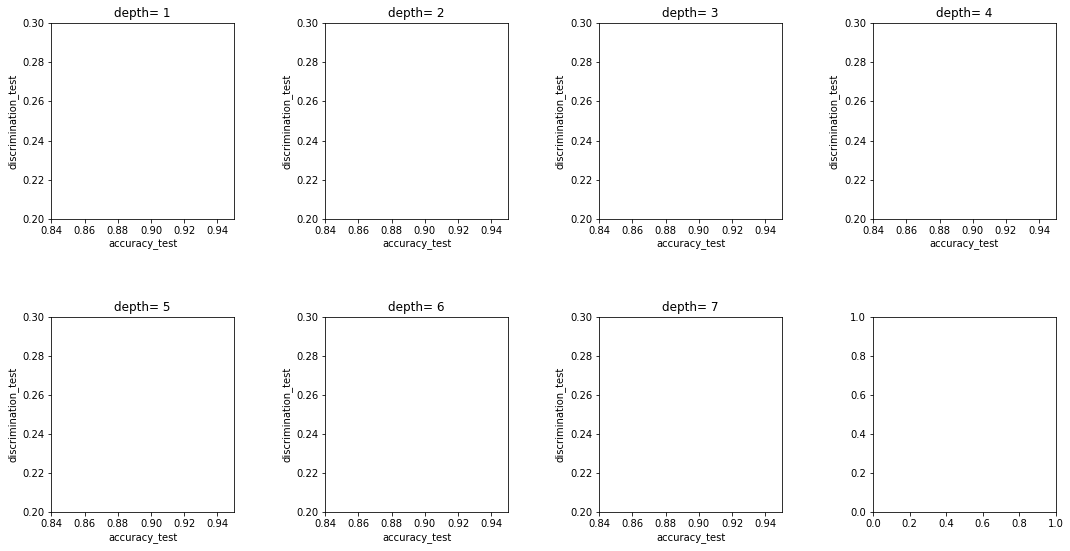

In [19]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

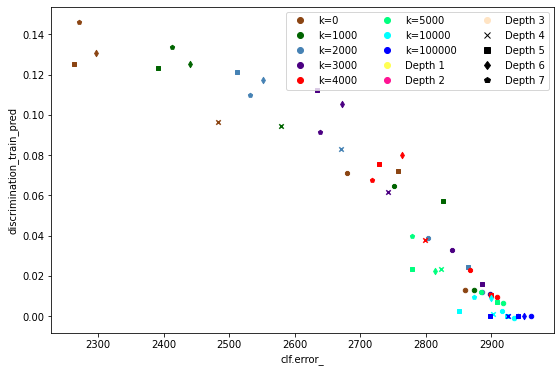

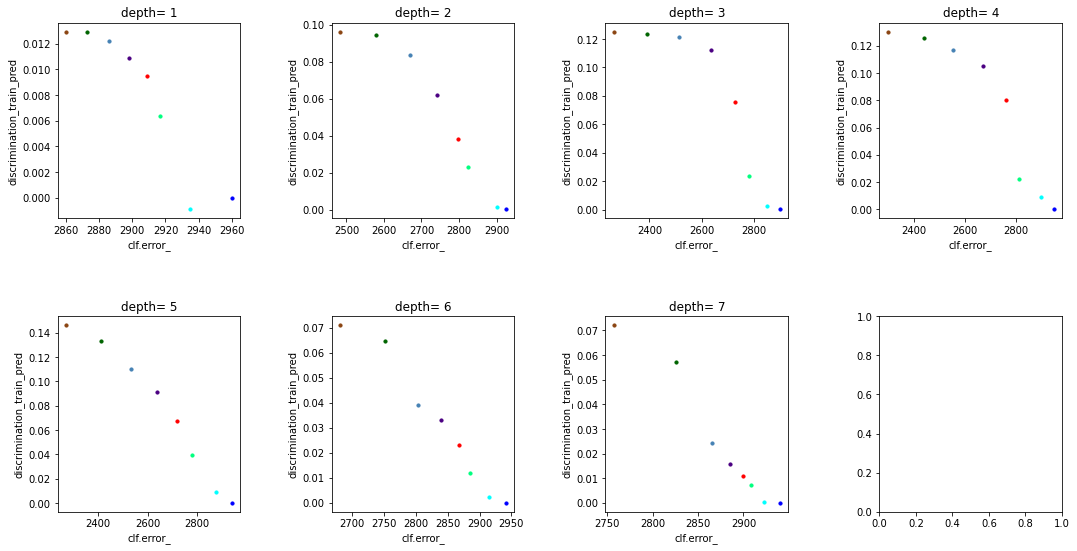

In [20]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

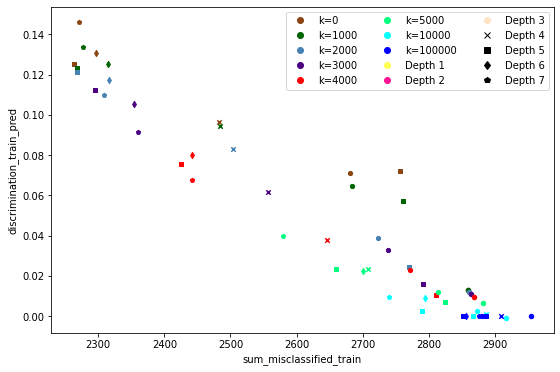

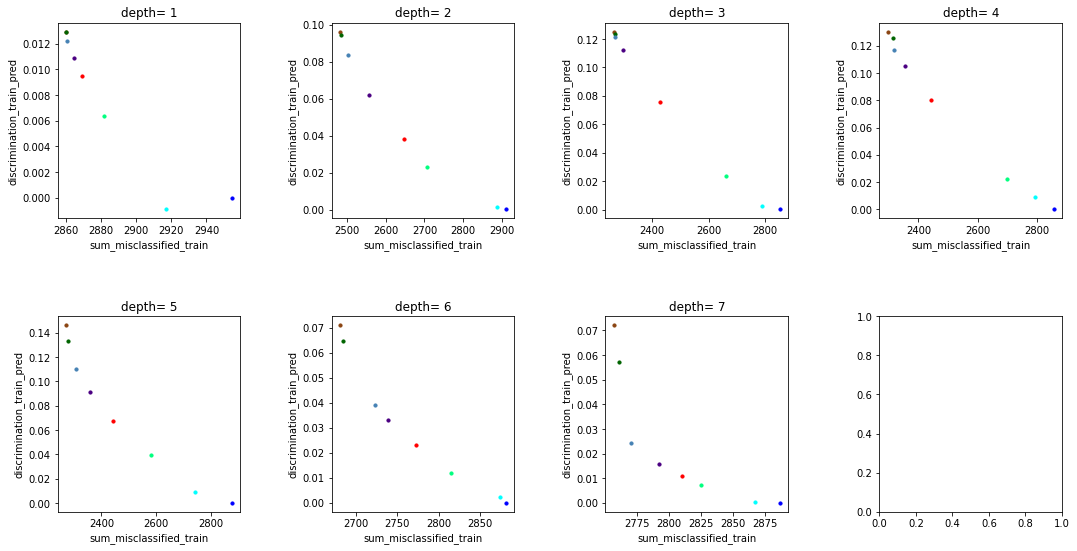

In [21]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

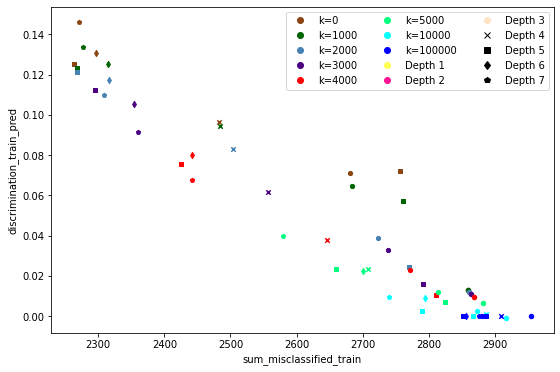

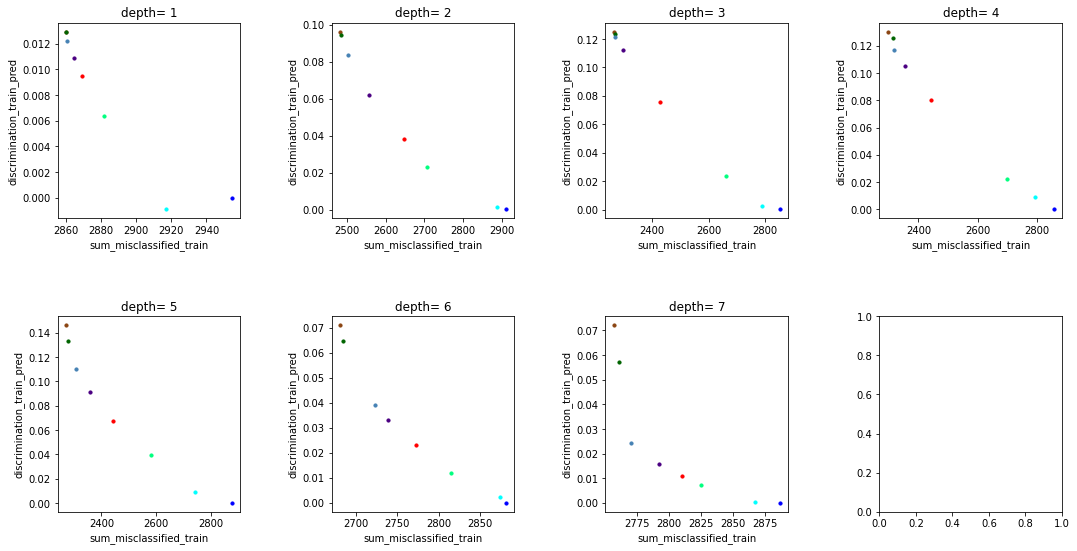

In [22]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

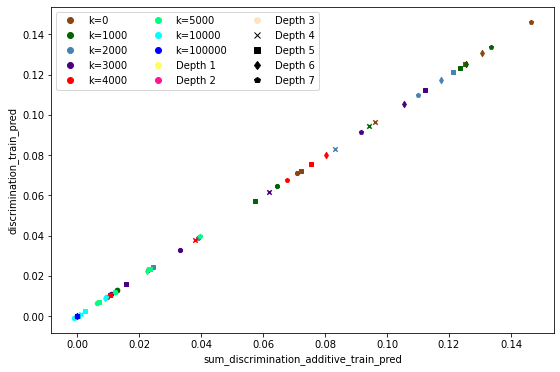

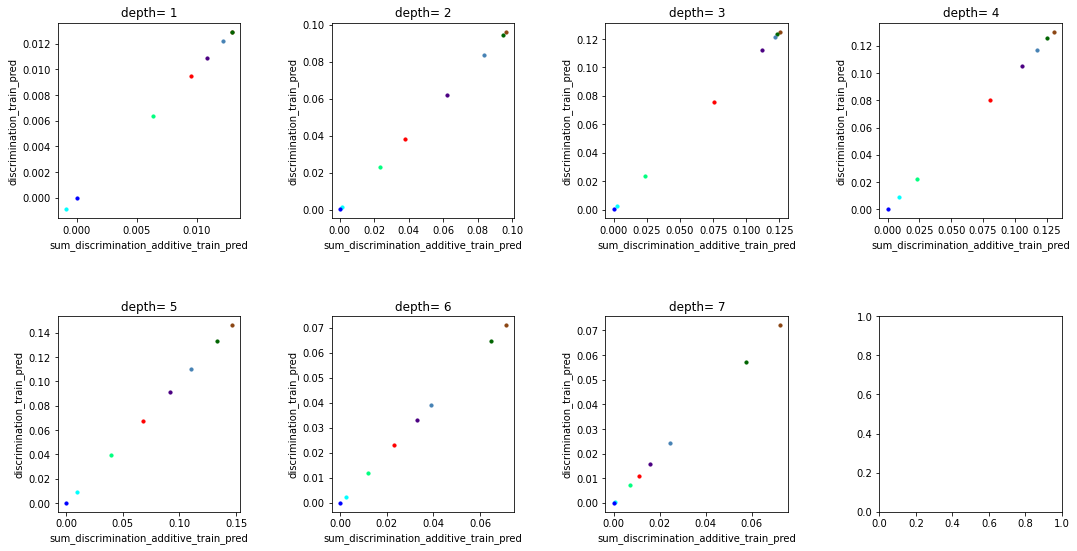

In [23]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

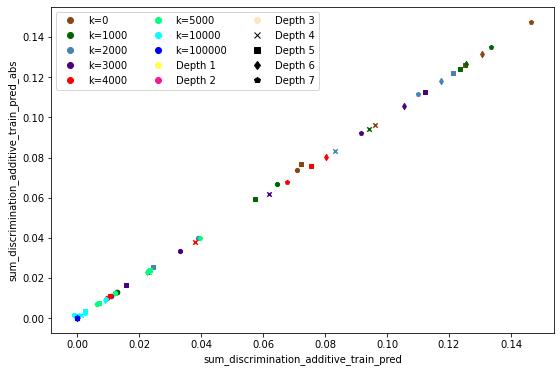

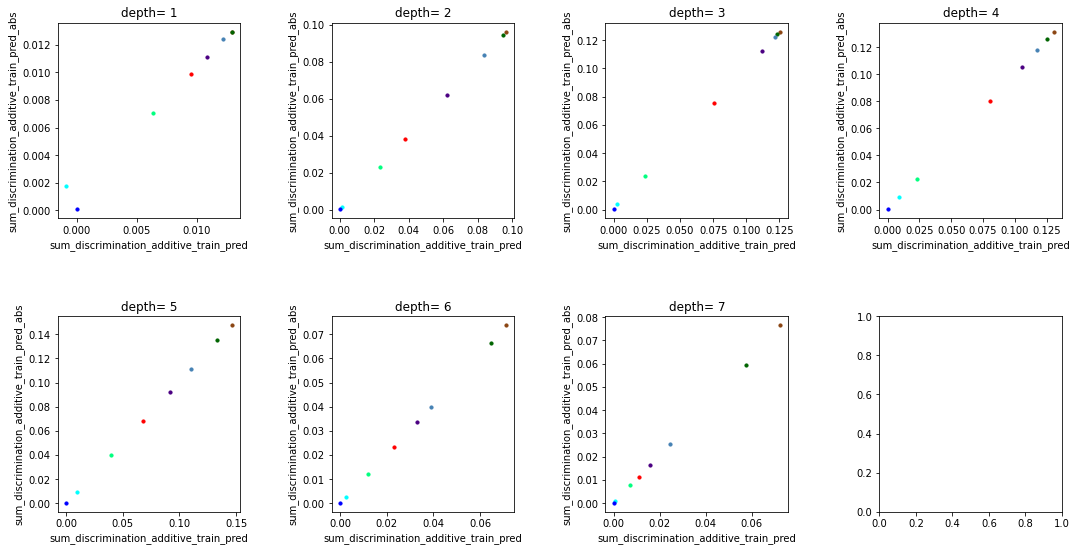

In [24]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)

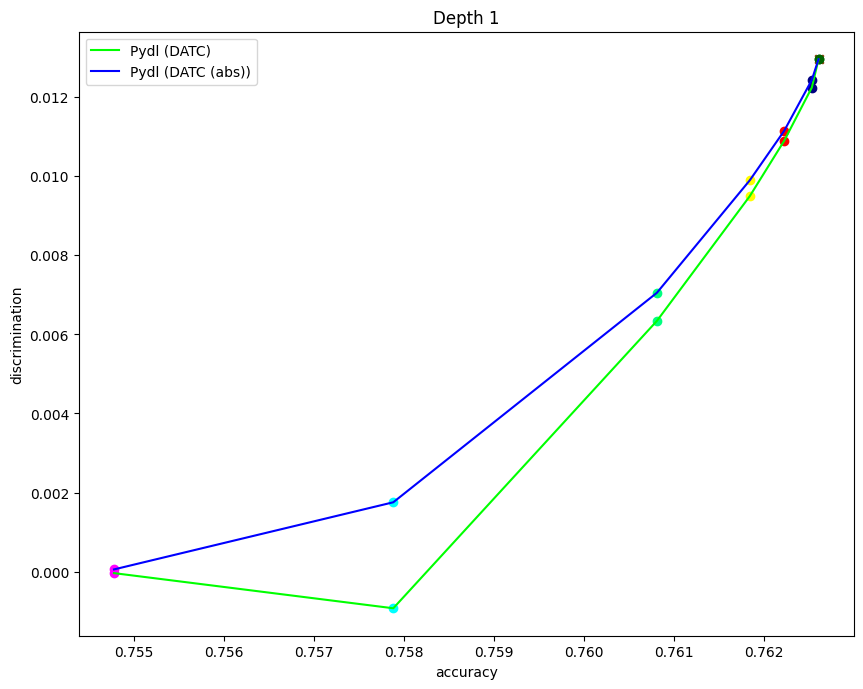

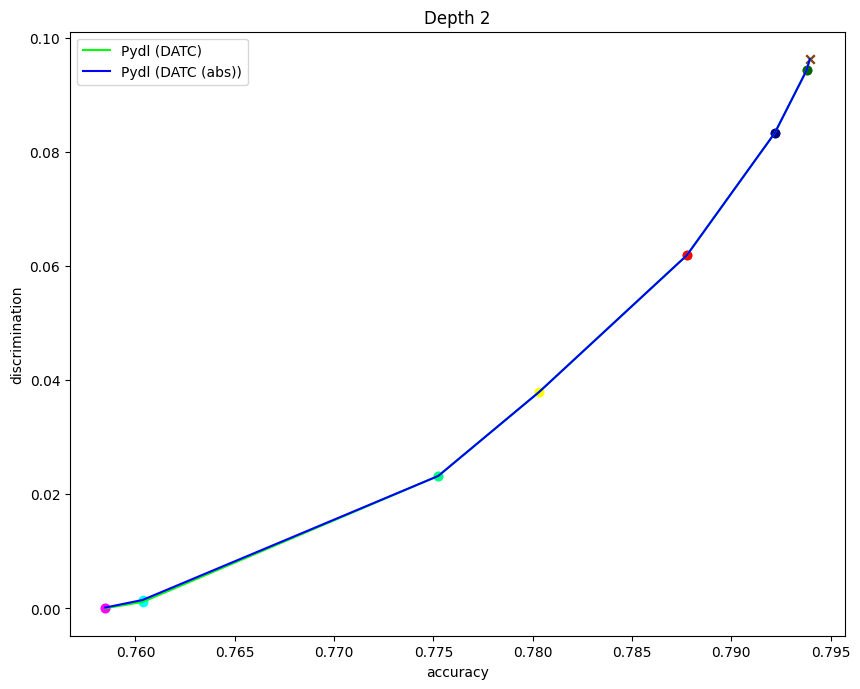

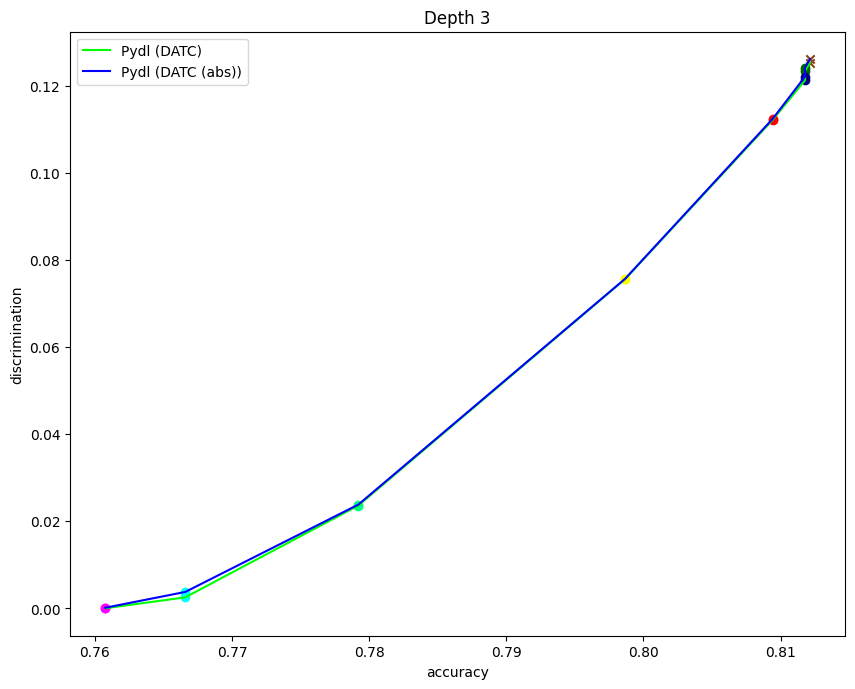

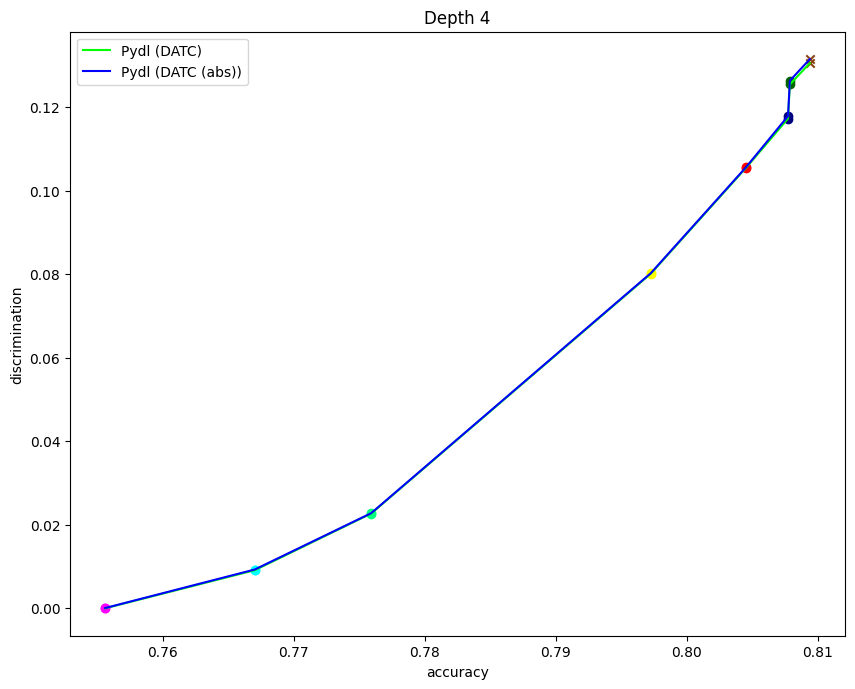

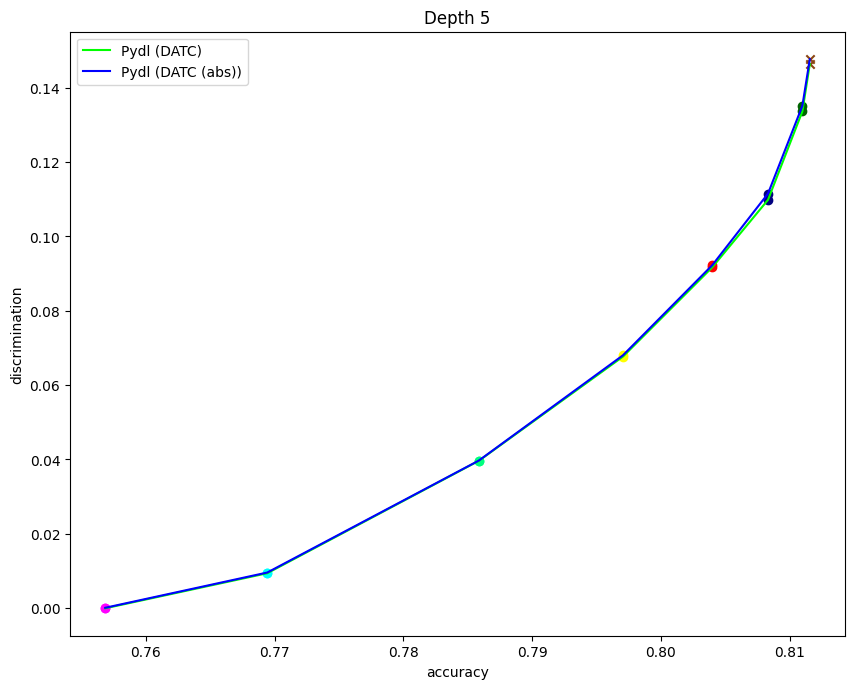

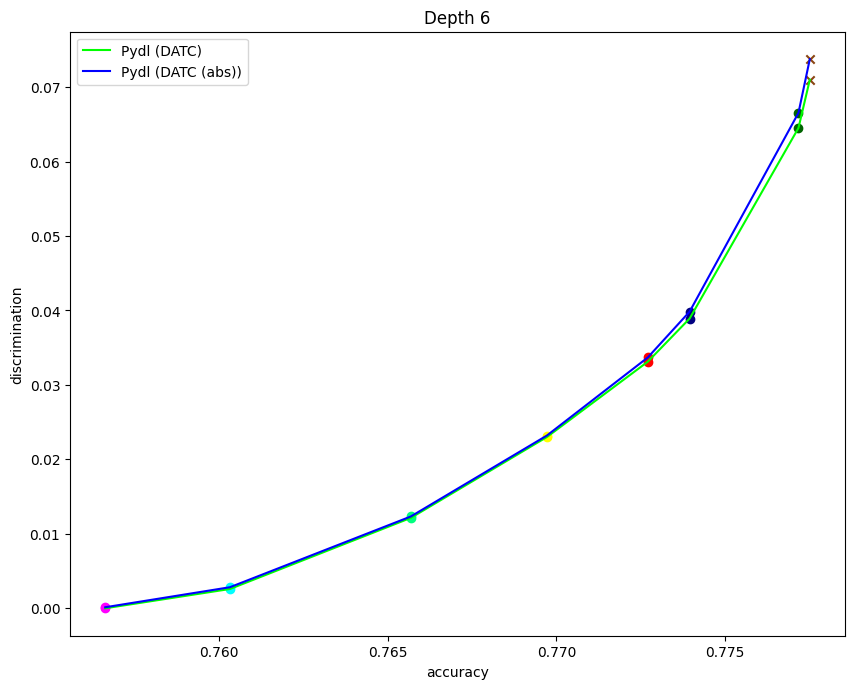

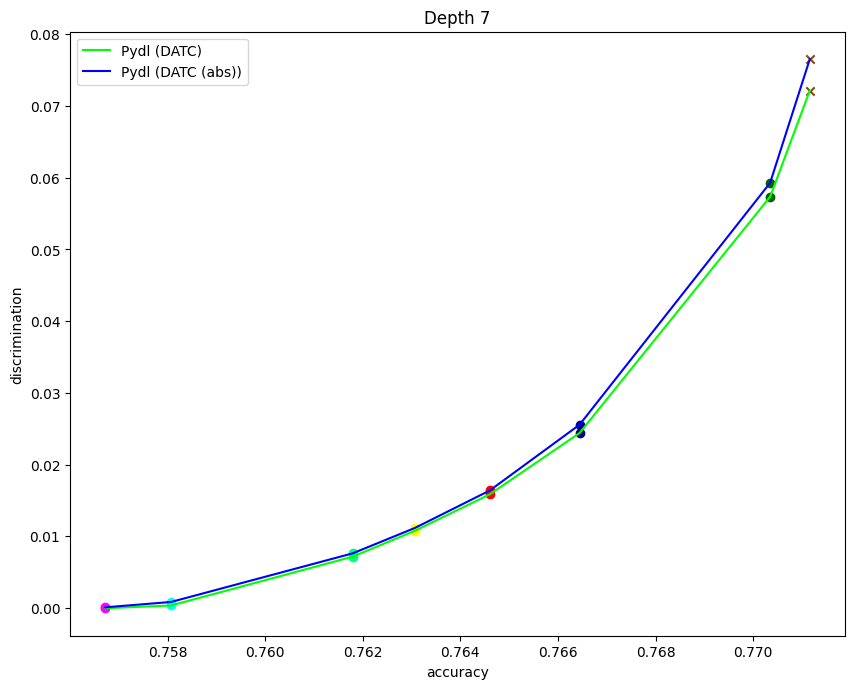

In [28]:
list_k = result["k"].unique()
_COLORS3 = ['#ff0000', '#00ff00', '#0000ff', '#008080']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS8 = ['#006400', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#00ffff', '#0000ff', '#1e90ff']
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#ffff00', '#00ff7f', '#00ffff', '#ff00ff', '#ffff54',
             '#ffe4c4']
_COLORS11 = ['#8b4513', '#006400', '#000080', '#ff0000', '#ffff00', '#00ff7f', '#00ffff', '#ff00ff', '#eee8aa', '#6495ed',
             '#ff69b4']

legends = ['< 0', '< 0.1', '< 0.2', '< 0.3', 'no relab']
fig, axes = plt.subplots()

for depth in result['depth'].unique():
    index_legends = 0
    y_values = list()
    x_values = list()
    y_values_pydl = list()
    x_values_pydl = list()
    axe2 = ("accuracy_pred", "sum_discrimination_additive_train_pred")
    x_axe = axe2[0]
    y_axe = axe2[1]
    index_legends = 0
    #for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
    for k in list_k:
        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        if index_legends == 0:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends], marker='x')
        else:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends])

        index_legends +=1

    plt.plot(x_values, y_values, label="Pydl (DATC)", c=_COLORS3[1])

    # PYDL 2
    y_values = list()
    x_values = list()

    axe2 = ("accuracy_pred", "sum_discrimination_additive_train_pred_abs")
    x_axe = axe2[0]
    y_axe = axe2[1]
    index_legends = 0
    #for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
    for k in list_k:
        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        if index_legends == 0:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends], marker='x')
        else:
            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=_COLORS11[index_legends])

        index_legends +=1

    plt.plot(x_values, y_values, label="Pydl (DATC (abs))", c=_COLORS3[2])


    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.legend()

    plt.show()